# Group

Divya Mani Adhikari (7043090)

Zurana Mehrin Ruhi (7023892)

Prashanth Pombala (7039928)

# Speaker-Independent Spoken Digit Recognition (xSDR)


One of the successful stories of deep neural networks is the proliferation of commercial of automatic speech recognition (ASR) systems. This project aims to explore one application of ML-powered ASR to the problem of spoken digit recognition (SDR). Since digits are widely used as unique identifiers for bank information, social security numbers, post codes, etc, SDR systems can be an efficient alternative to fully-fledged ASR systems since the domain is more predictable than other applications of ASR. 

In this project, we focus on developing a SDR system in a speaker-independent setting. That is, the speakers in the evaluation set are disjoint from the training set speakers. We do so because we expect real-world ASR systems to generalize to different speakers than those we have data for. Moreover, for many languages that are under-resourced, we have have (limited) annotated speech data from a single speaker, but we would still want the system to be deployed to work on any speaker of that language. We tackle the problem of spoken digit recognition as a sequence classification task. Concretely, the inputs are short audio clips of a specific digit (in the range 0-9), then the goal is to build deep neural network models to classify a short audio clip and predict the digit that was spoken.

# Notes

## Code Submission

You don't necessarily need to complete the code in this Jupyter Notebook, you are free to use another notebook or a python script file, as you would like. You are expected to submit the code by **22.03.2023**.

Your code should be clean and well commented. We also expect that if we decide to run it on our system, it should be straighforward to do so. We recommend creating a ```requirements.txt``` file with the names of all the libraries with their versions. If applicable, please mention the python version in a ```README.md``` file, which should also include instructions on how to run your code.

As mentioned for the assignments, always remember to cite the code with the links as comments, if you decide to use it from a public repository.

## Report Submission

With the code, you are also expected to submit a report with a maximum of 4 pages. You should write your report in LaTeX using this template for ACL 2023 [Overleaf Link](https://www.overleaf.com/latex/templates/acl-2023-proceedings-template/qjdgcrdwcnwp). Use this document to fill in any missing information that are not necessarily covered during your presentation for the sake of time in the presentation. While writing your report, we would highly encourgae you to cite the papers behind each tool / library / function that you might use for your experiments. We have also released an example on how to write equations in LaTeX [here](https://piazza.com/class/l9so16qqvk34hu/post/52).

You art also expected to submit this report with your code. You should provide the **.tex, .pdf and all image files** zipped with the same naming convention as it was in your assignment(s).

## Presentation

During the last week of March 2023, i.e. 27.03 -- 31.03, each team will be presenting their works for 15 minutes. We expect equal contribution from each member in delivery and content of the presentation. So roughly 5 minutes for one person, if you have 3 people in your team. There will be 5 minutes for some Q&A. At-least one person from your team should be present to do an in-person presentation, rest of your team could join remotely, if they are not present.

## Important Dates

 - Code & Report Submission: 22.03.2023 (08.00)
 - Presentation: 27.03.2023 -- 31.03.2023
 
 You'll get a precise date and time for your team's presentation at a later time.

### Grading

In this project, your final grades will be determined as follows:

 - **30%**: &emsp; Completing all the tasks
 - **30%**: &emsp; Providing scientific-backings for all the methods used
 - **20%**: &emsp; Quality of the content of the presentation
 - **20%**: &emsp; Delivery of the presentation

In [4]:
# Install necessary packages
# einops is required for some einsum operations
# ray[tune] is used for hyperparameter tuning/searching
!pip install einops "ray[tune]"

import random
import pickle
from collections import defaultdict, Counter

# add this to ignore warnings from Librosa
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display
import seaborn as sns

# for preprocessing
from sklearn  import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# dimensionality reduction
from sklearn.manifold import TSNE

# linear models
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

# evaluation metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import ConfusionMatrixDisplay

# for NN models
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch import nn, einsum
from einops import rearrange
from einops.layers.torch import Rearrange

# for handling data
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# for preprocessing audio
import torchaudio

# for grid search
from ray import tune, air
from ray.air import session
from ray.tune.schedulers import ASHAScheduler

# utils
from tqdm import tqdm

In [5]:
# set random seed
torch.manual_seed(42)

In [1]:
# we stored the dataset in google drive for easy access
# uncomment if you want to mount google drive
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


## Exploring the Dataset 

The speech samples are already divied into training, development, and test spilts. The splits are made in such way that evaluation speakers are not present in training split. You should use the splits as they are. 

**CAUTION:** 

In this project, you are not allowed to use any external data for this problem (at least for the main three tasks). Exploring the effect of additional datasets in this project can only included as a further step after completing the main requirements with the given data. 

In [2]:
# This variable defines where the data is located
# In particular, this should be the same directory that contains
# the 'SDR_metadata.tsv' file
data_dir = "drive/MyDrive/nnti_project/"

In [6]:
# read tsv file into a dataframe 
sdr_df = pd.read_csv(data_dir + 'SDR_metadata.tsv', sep='\t', header=0, index_col='Unnamed: 0')
sdr_df.file = sdr_df.file.apply(lambda x: data_dir + x)

In [ ]:
sdr_df.head()

,identifier,speaker,split,label,file
0,5_theo_23,theo,TRAIN,5,drive/MyDrive/nnti_project/speech_data/5_theo_...
1,2_yweweler_39,yweweler,TEST,2,drive/MyDrive/nnti_project/speech_data/2_ywewe...
2,6_yweweler_34,yweweler,DEV,6,drive/MyDrive/nnti_project/speech_data/6_ywewe...
3,6_yweweler_16,yweweler,DEV,6,drive/MyDrive/nnti_project/speech_data/6_ywewe...
4,9_yweweler_2,yweweler,TEST,9,drive/MyDrive/nnti_project/speech_data/9_ywewe...


In [ ]:
set(sdr_df.speaker.values)

{'george', 'jackson', 'lucas', 'nicolas', 'theo', 'yweweler'}

In [ ]:
# explore one sample: 7_theo_0
sdr_df.loc[sdr_df['identifier'] == '7_theo_0']

,identifier,speaker,split,label,file
700,7_theo_0,theo,TRAIN,7,drive/MyDrive/nnti_project/speech_data/7_theo_...


In [ ]:
sample_wav_file = sdr_df.loc[sdr_df['identifier'] == '7_theo_0'].file[700]

## The Speech Waveform

The acoustic realization of speech segment can be (digitally) viewed as a time-variant wavform $\mathbf{S} \in \mathbb{R}^{n}$. Here, $n$ depends on both the duration of the speech segment and the sampling rate of the continous speech singal. Let's check out one sample from the data set. 

In [ ]:
# play and listen to a sample 
SAMPLING_RATE = 8000 # This value is determined by the wav file, DO NOT CHANGE

x, sr = librosa.load(sample_wav_file, sr=SAMPLING_RATE) #, 
ipd.Audio(x, rate=sr)

In [ ]:
# plot as a waveform 
fig, ax = plt.subplots(figsize=(10, 2), sharex=True)

img = librosa.display.waveshow(y=x, sr=sr, alpha=0.75, x_axis='time', color='blue')

ax.set(title='Amplitude waveform')
ax.set_ylabel('Amplitude')
ax.label_outer()

In [ ]:
# sample duration in milliseconds
(1000*len(x))/SAMPLING_RATE

428.5

In the cell above, you can see the temporal duration of the audio is 428.5 milliseconds. For digits in the range 0-9, the duration of the speech segment should be around 0.5 seconds with reasonable variation depending on speech rate (i.e., how fast the speaker speaks). 

## The Speech Signal Representation - Mel Spectrograms

Humans can recognize and differentiate different speech sounds based on the frequency characteristics of the sounds. For machine learning applications, human speech is represented using spectro-temporal features in the [Mel-scale](https://en.wikipedia.org/wiki/Mel_scale) extracted from the speech sample. Mel-scale features are inspired by human speech perception and auditory processing whereby the human ear has difference sensitivity (or resolution) in differet frequency bandes. That is, the human ear can better recognize differences in in lower range frequences, while higher range frequences have a lower resolution. The Mel-scale is linear for frequencies in the range (0-1kHz), and logarithmic for frequencies above 1kHz.

In the spectro-temporal representation of speech, a speech sample can be seen as a sequence of $T$ spectral vectors as $\mathbf{X} = (\mathbf{x}^1, \mathbf{x}^2, \dots, \mathbf{x}^T)$. Each spectral vector $\mathbf{x}^t \in \mathbb{R}^{k}$ at time-step $t$ is extracted from a short speech segment (~25 milliseconds) with the assumption that the signal is time-invariant in this small time window. Here, $k$ is the number of frequency bands in the [spectrogram](https://en.wikipedia.org/wiki/Spectrogram) and this is a parameter of the feature extraction pipeline. The representation is based on the Fourier transform to convert the temporal signal into the frequency domain. 

In automatic speech recognition (ASR) research and applications, spectral vectors are usually referred to as "acoustic frames". Morover, adjacent frames are extracted with some overlap between them, usually ~10 milliseconds. 

In [ ]:
def extract_melspectrogram(signal, sr, num_mels):
    """
    Given a time series speech signal (.wav), sampling rate (sr), 
    and the number of mel coefficients, return a mel-scaled 
    representation of the signal as numpy array.
    """
    
    mel_features = librosa.feature.melspectrogram(y=signal,
        sr=sr,
        n_fft=200, # with sampling rate = 8000, this corresponds to 25 ms
        hop_length=80, # with sampling rate = 8000, this corresponds to 10 ms
        n_mels=num_mels, # number of frequency bins, use either 13 or 39
        fmin=50, # min frequency threshold
        fmax=4000 # max frequency threshold, set to SAMPLING_RATE/2
    )
    
    # for numerical stability added this line
    mel_features = np.where(mel_features == 0, np.finfo(float).eps, mel_features)

    # 20 * log10 to convert to log scale
    log_mel_features = 20*np.log10(mel_features)

    # feature scaling
    scaled_log_mel_features = preprocessing.scale(log_mel_features, axis=1)
    
    return scaled_log_mel_features

In [ ]:
melspectrogram = extract_melspectrogram(x, sr, num_mels=13)

melspectrogram.shape

Note that the shape of the array (K x T) represents the number of frequency bands (K) and the number of spectral vectors in this representation (here, K=13, T=43). K is a hyperparameter and the recommended values in ASR research are (13, 39, 81, etc). Here, we fix K = 13. On the other hand, T varies from sample to sample depending on the duration of the sample.  

In [ ]:
# plot and view the spectrogram

fig, ax = plt.subplots(figsize=(10, 2), sharex=True)

img = librosa.display.specshow(
    melspectrogram, 
    sr=sr, 
    x_axis='time', 
    y_axis='mel', 
    cmap='viridis', 
    fmax=4000, 
    hop_length=80
)

ax.set(title='Log-frequency power spectrogram')

ax.label_outer()

As you can see above from the figure, the spectrogram representation can be viewed as a matrix $\mathbf{X} \in \mathbb{R}^{T} \times \mathbb{R}^{k}$.  

## Task I
1. One problem with the spectrogram as a speech feature represetation is that different speech samples would have dfferent durations due to inherent speech variability (e.g., speech rate, speaker dialect, etc). That is, the $T$ in the $(T \times k)$-dimensional representation would be different for each sample. Therefore, for the baseline model, we will implement a method to have a fixed-size representation for all speech samples. Write a function downsample_spectrogram(X, N) that takes as input a spectrogram $\mathbf{X} \in \mathbb{R}^{T \times k}$ and a parameter N <= 25. The function should (1) make N equally-sized splits of S across the time-axis, (2) apply a pooling technique (e.g., mean pooling) to each split across the frequency axis to obtain an array that represents a downsampled version of the spectrogram $\mathbf{X}' \in \mathbb{R}^{N \times k}$, and (3) re-arange $\mathbf{X}'$ as a vector $\mathbf{v} \in \mathbb{R}^{Nk}$.    

2. Using the downsample_spectrogram(X, N) function, transform all the speech samples into vectors $\mathbf{v} \in \mathbb{R}^{Nk}$. 

3. Given the speaker-based train/dev/test spilts in the SDR_metadata.tsv, fit a linear model on the training samples. That is, your model should be build on data from 4 speakers {'nicolas', 'theo' , 'jackson',  'george'}. Hint: you can experiment with a few model alternatives in the SGDClassifier module in scikit-learn. 

4. Evaluate you model on the dev and test splits. Use accuracy as an evaluation metric. Analyze the model performance using a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) of the all possible labels (0-9), Analyze [precision, recall](https://en.wikipedia.org/wiki/Precision_and_recall), [F1-score](https://en.wikipedia.org/wiki/F-score) for each label. Report your observation.

In [ ]:
def downsample_spectrogram(X, N):
    """
    Given a spectrogram of an arbitrary length/duration (X ∈ K x T), 
    return a downsampled version of the spectrogram v ∈ K * N
    """
    # Split the spectrogram into N equal parts
    v = np.split(X, indices_or_sections=N, axis=1)
    v = np.array(v)

    # Take the average
    v = np.mean(v, axis=2)

    # Flatten the matrix into an array
    v = v.flatten()
    return v

In [ ]:
def preprocess_extract_and_downsample_mfcc(files, sr=8000, num_mels=13, N=25):
  """
  Extract the MFCC from the raw waveform, then downsample

  returns: downsampled spectrogram of shape (len(files), K, N)
  """
  output = np.zeros((len(files), num_mels*N))
  for idx, f in enumerate(tqdm(files)):
    x, sr = librosa.load(f, sr=sr)
    x_mfcc = extract_melspectrogram(x, sr=sr, num_mels=num_mels)

    # pad with zeros at end to make equal division possible
    x_mfcc = np.pad(x_mfcc, pad_width=((0,0), (0, N - x_mfcc.shape[1] % N)))
    
    mfcc_downsampled = downsample_spectrogram(x_mfcc, N=N)
    output[idx, :] = mfcc_downsampled
  return output

## Baseline Model

In [7]:
# prepare data and split

# These only contain the file location string
# the mel spectrograms will be extracted next
train_files = sdr_df.file[sdr_df.split == "TRAIN"].tolist()
dev_files = sdr_df.file[sdr_df.split == "DEV"].tolist()
test_files = sdr_df.file[sdr_df.split == "TEST"].tolist()

# These contain the labels for train/dev/test set
train_labels = sdr_df.label[sdr_df.split == "TRAIN"].tolist()
dev_labels = sdr_df.label[sdr_df.split == "DEV"].tolist()
test_labels = sdr_df.label[sdr_df.split == "TEST"].tolist()

In [ ]:
# let's see how many examples are there in each set
len(train_files), len(dev_files), len(test_files)

(2000, 497, 503)

In [ ]:
# Extract the MFCC and downsample it using the previous function
train_set = preprocess_extract_and_downsample_mfcc(train_files)
dev_set = preprocess_extract_and_downsample_mfcc(dev_files)
test_set = preprocess_extract_and_downsample_mfcc(test_files)

100%|██████████| 503/503 [01:49<00:00,  4.61it/s]


In [8]:
# The preprocessed and downsampled spectrograms was saved as a pickle file
# This part is used for loading it. 
#
# mfcc_dict = pickle.load(open(data_dir + "mfcc_downsampled.pkl", "rb"))
# train_set = mfcc_dict["train"]
# dev_set = mfcc_dict["dev"]
# test_set = mfcc_dict["test"]

In [9]:
# This dictionary is used for storing the dev/test predictions
# for each model
predictions = {}

Train accuracy: 0.94
Dev accuracy: 0.31
Test acc: 0.36



Text(0.5, 0.98, 'Confusion matrices for Linear SGDClassifier (SVM)')

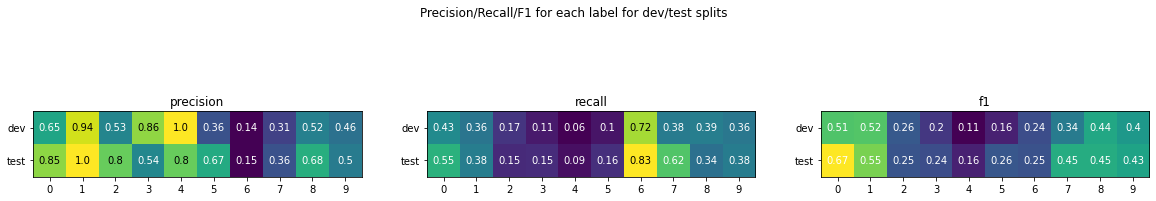

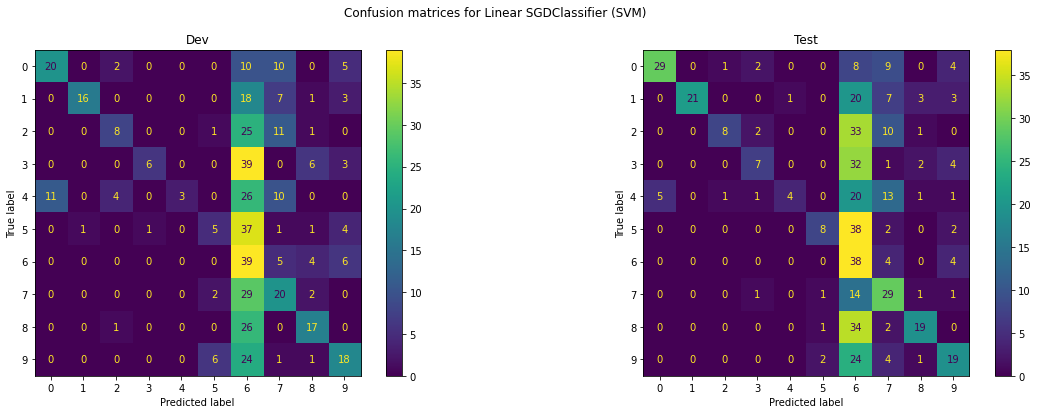

In [ ]:
# train a linear model 

# First create a pipeline that first scales the input
# and then fits a linear model to the processed data
# 
# We are using SGDClassifier with hinge loss, which is a SVM model
# We are using L2 regularization with optimized learning rate to fit the data
clf = make_pipeline(StandardScaler(), SGDClassifier(loss="hinge", penalty="l2", alpha=0.0001, learning_rate="optimal", random_state=42))
clf.fit(train_set, train_labels)

# evaluate the model using accuracy metric
train_preds = clf.predict(train_set)
dev_preds = clf.predict(dev_set)
test_preds = clf.predict(test_set)

# Store the predictions
predictions["svm"] = {"train": train_preds, "dev": dev_preds, "test": test_preds}

print("Train accuracy: {:.2f}".format(accuracy_score(train_labels, train_preds)))
print("Dev accuracy: {:.2f}".format(accuracy_score(dev_labels, dev_preds)))
print("Test acc: {:.2f}\n".format(accuracy_score(test_labels, test_preds)))

# report precision, recall, F1-score for each label 
dev_p, dev_r, dev_f1, dev_support = precision_recall_fscore_support(dev_labels, dev_preds, average=None)
test_p, test_r, test_f1, test_support = precision_recall_fscore_support(test_labels, test_preds, average=None)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))

dataset_labels = ["dev", "test"]
evaluation_labels = ["precision", "recall", "f1"]
stacked_precision = np.stack([dev_p, test_p])
stacked_recall = np.stack([dev_r, test_r])
stacked_f1 = np.stack([dev_f1, test_f1])
stacked_evaluations = [stacked_precision, stacked_recall, stacked_f1]
for idx, ax in enumerate(axes):
  im = ax.imshow(stacked_evaluations[idx])
  ax.set_title(evaluation_labels[idx])
  ax.set_yticks(np.arange(len(dataset_labels)), dataset_labels)
  ax.set_xticks(np.arange(10), range(10))

  for i in range(stacked_evaluations[idx].shape[0]):
    for j in range(stacked_evaluations[idx].shape[1]):
      value = np.round(stacked_evaluations[idx][i][j], 2)
      text = ax.text(j, i, value, ha="center", va="center", color="w" if value < 0.7 else "black")
fig.suptitle("Precision/Recall/F1 for each label for dev/test splits")

# analyze the confusion matrix of the baseline 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

ConfusionMatrixDisplay.from_predictions(dev_labels, dev_preds, labels=clf.classes_, ax=axes[0])
axes[0].set_title("Dev")

ConfusionMatrixDisplay.from_predictions(test_labels, test_preds, labels=clf.classes_, ax=axes[1])
axes[1].set_title("Test")

fig.suptitle("Confusion matrices for Linear SGDClassifier (SVM)")

### Analysis

For the baseline, we used SGDClassifier with hinge loss (which is the same as a SVM). Using this model, we we're able to obtain 94% accuracy on the training set. But, this didn't seem to generalize well as our dev set accuracy was only 31% and our test set accuracy was only 36%. We also tried other loss functions but they also showed similar (or somewhat worse) performance compared to SVM.

Next, we calculated the precision, recall and F1 score for each digit for the dev and test set as shown in above figure. As precision is the ration of the true positives in the predictions made by the model to the total positive predictions made by the model, there seems to be high false positive rate particularly for the digit 6, both in the dev and the test set. The digit 1 and 4 show high precision in the dev set which would mean they have low false positives. And, in the case of test set, we can see that the digits 0, 1, 2, 4 have high precision.

Next, recall is the ratio of the true positives predicted by the model to the total true positive labels in the dataset. Most of the digits seem to have low recall value (< 0.5) in both the dev and test set which would mean they have high false negative predictions. Only the digit 6 seems to have somewhat high recall value.

Thus, F1 score, which is the harmonic mean of the precision and recall, was also calculated. F1 score would be high if both precision and recall are high. Only a few digits seem to have a F1 score greater than 0.5 in both the dev and test set. The digit 0 which has a high precision value and a decent recall (compared to other digits) in the test, showed a good F1 score. Other digits seem to have low F1 score probably due to their low Recall score.


Next, we also calculated the confusion matrix as shown above for the dev and test set. From it, we can see that the linear SVM model seems to confuse most of the digits with the digit 6 and 7 as seen with the high number of predictions of 6 and 7. This is the case in both the dev and test set.

## Task II
1. Having established a baseline with a linear model trained on a downsampled signal representation of the speech segment, this task aims to learn a classifier based on the full speech segment. To this end, you will implement a neural model that is suitable for sequential data such as recurrent DNN, convolutional DNN with 1-D temporal convolution, or an audio transformer. The model should take the acoustic sample as it is (i.e., the Mel spectrogram could have an arbitrary length) without the need to downsample the segment. You need to implement at least two of the aforementioned models. Do the neural models improve accuracy over the baseline model? Do you observe any signs of overfitting to the training data? How do the hyperparameters affect the model performance? Report and discuss your observations.        

2. Evaluate your (best) neural models and compare to the baseline model using the same evalution process as in task I.4. 

3. Use a dimensionality reduction algorithm such as t-SNE \[[1](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding),[2](https://pypi.org/project/tsne-torch/),[3](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)\] or [UMAP](https://umap-learn.readthedocs.io/en/latest/basic_usage.html) to analyze how the different models seperate the different classes (the last non-linear layer in your model). Compare to the downsampled representation you used in the baseline and report your observations.

4. Are the differences between the different models statistically significant? To answer this question, you need to implement a statistical significance test based on bootstrapping method. To read more how to estiame p-values based on bootstrapping, we recommend the materials on this paper https://aclanthology.org/D12-1091.pdf. Include the baseline model in your evaluation. 

In [48]:
# Use GPU if it's available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on: {device}")

Training on: cpu


## Create data handlers

In [23]:
class AudioDataset(Dataset):
  """
  Creates a Pytorch dataset for handling the data and feeding to the model
  """
  def __init__(self, files, labels, n_mfcc=80, n_fft=200, hop_length=80, sr=8000, transforms=[]):
    """
    param files: list of audio file locations
    param labels: corresponding labels of the audio files
    param n_mfcc: number of frequency bins
    param n_fft: length of the FFT window
    param hop_length: no. of samples between successive frames
    param sr: the sampling rate
    transforms: list of torchaudio's transformation function to apply to the raw waveform

    returns: tuple(mel spectrogram, length of mel spectrogram, label)
    """
    self.waveform_files = files
    self.labels = labels
    self.sr = sr
    self.mel_transform = torchaudio.transforms.MFCC(
        sample_rate=self.sr,
        n_mfcc=n_mfcc,
        melkwargs={
            "n_fft": n_fft,
            "n_mels": n_mfcc,
            "hop_length": hop_length,
            "mel_scale": "htk"
        })
    self.transforms = []

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    wv, sr = torchaudio.load(self.waveform_files[idx])

    # transform to mel spectrogram
    wv = self.mel_transform(wv)

    # apply any other transformations provided
    for t in self.transforms:
      wv = t(wv)
    wv = wv.permute(0, 2, 1)
    return (wv, wv.shape[1], self.labels[idx])

In [24]:
# Create dataset instances for train/dev/test set
train_ds = AudioDataset(train_files, train_labels)
dev_ds = AudioDataset(dev_files, dev_labels)
test_ds = AudioDataset(test_files, test_labels)

# Create dataloader instances that can be directly fed into the model
# We are using a batch_size of 1, which would mean we'll be using 
# stochastic gradient descent instead of minibactch SGD
#
# We tried padding the data to allow for larger batch
# but it didn't seem to work, so we used a single batch for all our tests
train_dl = DataLoader(train_ds, batch_size=1, shuffle=True)
dev_dl = DataLoader(dev_ds, batch_size=1, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=False)

## Helper functions for training/evaluating

In [25]:
def evaluate(model, dataloader, disable_progress=False, rnn=False):
    """
    Evaluate the model on the given dataloader

    param model: the instance of Pytorch NN model
    param dataloader: the instance of Pytorch dataloader (usually test/val dataloader)
    disable_progress: disables the tqdm progress bar

    returns: tuple(list of predictions, list of corresponding true labels)
    """
    predictions = []
    labels = []
    model.eval()
    for (inp_wave, inp_len, label) in tqdm(dataloader, position=0, leave=True, disable=disable_progress):
          
        inp_wave = inp_wave.squeeze(0).to(device)
        inp_len = inp_len.to(device)
        label = label.to(device)
        
        # Forward pass
        if rnn:
          # if model is rnn then send empty hidden & context values
          out = model(inp_wave, None, None)
        else:
          # for conformer, send input wave and input length
          out = model(inp_wave, inp_len)

        # Get correct softmax probs.
        # from the log softmax output
        out = torch.exp(out)

        out = torch.argmax(out, dim=1)

        out = list(out.cpu().numpy())
        labels_batch = list(label.cpu().numpy())
        
        predictions.extend(out)
        labels.extend(labels_batch)

    return predictions, labels

In [26]:
def train(model, train_dl, val_dl, criterion, optimizer, epochs=5, early_stop=True, patience=5, checkpoint_name="checkpoint.pt", rnn=False):
    """
    Train the model on the given data

    param model: the instance of Pytorch NN model
    param train_dl: the training dataloader to be trained on
    param val_dl: the validation dataloader for evaluating (in training and in early stopping)
    param criterion: the loss function
    param optimizer: the optimizer function
    param epochs: the number of epochs to train the model for
    param early_stop: If the early stopping should be used or not
    param patience: (for early stopping) the number of times to wait before stopping training
    param checkpoint_name: (for early stopping) the name of the model checkpoint
    """
    losses_to_plot = []
    validation_accuracy = []

    # initialize the earlystopping module
    early_stopping = EarlyStopping(patience=patience, verbose=True, path=checkpoint_name)

    for epoch in range(epochs):
        epoch_loss = []
        for i, (inp_wave, inp_len, label) in enumerate(pbar := tqdm(train_dl)):  
          
            inp_wave = inp_wave.squeeze(0).to(device)
            inp_len = inp_len.to(device)
            label = label.to(device)
            
            # Forward pass
            if rnn:
              # if model is rnn then send empty hidden & context values
              outputs = model(inp_wave, None, None)
            else:
              # for conformer, send input wave and input length
              outputs = model(inp_wave, inp_len)

            loss = criterion(outputs, label)

            # Save the step loss for plotting
            losses_to_plot.append(loss.item())

            # Save the step loss for calculating mean error in epoch
            epoch_loss.append(loss.item())
            
            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # add loss value to the tqdm progress bar
            pbar.set_postfix_str(f"Loss: {loss.item():.4f}")

        epoch_loss_mean = sum(epoch_loss)/len(epoch_loss)

        # Evaluate on validation set
        preds, labs = evaluate(model, val_dl, rnn=rnn)
        accuracy = accuracy_score(preds, labs)
        validation_accuracy.append(accuracy)

        if early_stop:
          # if early stopping is enabled, store the validation scores
          early_stopping(accuracy, model)

          if early_stopping.early_stop:
            # if the patience has been crossed, the training is stopped and
            # the checkpoint file contains the best model according to the
            # validation accuracy
            print("Stopping early at epoch [{}/{}]".format(epoch+1, epochs))
            return losses_to_plot, validation_accuracy

        print("Epoch [{}/{}] Loss: {:.4f} Val. Acc: {:.4f}".format(epoch+1, epochs, epoch_loss_mean, accuracy))
          
    return losses_to_plot, validation_accuracy

In [10]:
class EarlyStopping:
    """
    This implementation was adapted from: https://github.com/Bjarten/early-stopping-pytorch
    The original implementation stored and compared validation loss and this implementation
    uses the validation accuracy for early stopping
    
    Early stops the training if validation accuracy doesn't improve after a given patience.
    """

    def __init__(
        self,
        patience=7,
        verbose=False,
        delta=0,
        path="../output/checkpoint.pt",
        trace_func=print,
    ):
        """
        Args:
            patience (int): How long to wait after last time validation accuracy improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation accuracy improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_acc_min = -np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_acc, model):

        score = val_acc

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_acc, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(
                f"EarlyStopping counter: {self.counter} out of {self.patience}"
            )
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_acc, model)
            self.counter = 0

    def save_checkpoint(self, val_acc, model):
        """Saves model when validation accuracy increase."""
        if self.verbose:
            self.trace_func(
                f"Validation accuracy increased ({self.val_acc_min:.6f} --> {val_acc:.6f}).  Saving model ..."
            )
        torch.save(model.state_dict(), self.path)
        self.val_acc_min = val_acc

## A simple RNN

We decided to use a simple RNN architecture that uses a single LSTM layer, a dropout layer for regularization and a linear layer for output.

In [ ]:
class RNNClassifier(nn.Module):
  """
  A simple RNN model that uses LSTM for audio classification
  """
  def __init__(self, embeds_dim, hidden_dim, n_classes=10, dropout=0.1):
    """
    param embeds_dim: the size of the embeddings
    param hidden_dim: the size of the internal hidden layers
    param n_classes: the number of classes
    param dropout: the dropout probability
    """
    super(RNNClassifier, self).__init__()

    self.hidden_dim = hidden_dim
    self.lstm = nn.LSTM(embeds_dim, hidden_dim)
    self.dropout = nn.Dropout(p=dropout)
    self.linear = nn.Linear(hidden_dim, n_classes)

  def forward(self, inp, hid_prev=None, ctx_prev=None):

    # If hidden representation (from previous output) is not given,
    # initialize a zero vector to feed to the LSTM model
    if not isinstance(hid_prev, torch.Tensor):
      hid_prev = torch.zeros(1, inp.shape[1], self.hidden_dim)

    # If context representation (from previous output) is not given,
    # initialize a zero vector to feed to the LSTM model
    if not isinstance(ctx_prev, torch.Tensor):
      ctx_prev = torch.zeros(1, inp.shape[1], self.hidden_dim)

    out, (hid, ctx) = self.lstm(inp, (hid_prev, ctx_prev))
    
    out = self.dropout(out)

    out = self.linear(out)
    out = torch.mean(out, dim=1)
    out = F.log_softmax(out, dim=-1)
    return out

In [ ]:
# Initialize the RNN model
# In this case, the embedding size is 80, the hidden size is 256
# there are 10 classes to predict and the dropout probabilty is 0.1
rnn_model = RNNClassifier(embeds_dim=80, hidden_dim=256, n_classes=10, dropout=0.1).to(device)

100%|██████████| 497/497 [02:41<00:00,  3.07it/s]


Validation loss decreased (-inf --> 0.565392).  Saving model ...
Epoch [1/30] Loss: 1.7429 Val. Acc: 0.5654


100%|██████████| 497/497 [00:03<00:00, 140.97it/s]


Validation loss decreased (0.565392 --> 0.615694).  Saving model ...
Epoch [2/30] Loss: 0.9572 Val. Acc: 0.6157


100%|██████████| 497/497 [00:04<00:00, 112.43it/s]


EarlyStopping counter: 1 out of 5
Epoch [3/30] Loss: 0.5806 Val. Acc: 0.6076


100%|██████████| 497/497 [00:02<00:00, 215.18it/s]


EarlyStopping counter: 2 out of 5
Epoch [4/30] Loss: 0.3817 Val. Acc: 0.6097


100%|██████████| 497/497 [00:02<00:00, 230.00it/s]


EarlyStopping counter: 3 out of 5
Epoch [5/30] Loss: 0.2587 Val. Acc: 0.5473


100%|██████████| 497/497 [00:01<00:00, 255.45it/s]


EarlyStopping counter: 4 out of 5
Epoch [6/30] Loss: 0.1858 Val. Acc: 0.5775


100%|██████████| 497/497 [00:01<00:00, 261.40it/s]


EarlyStopping counter: 5 out of 5
Stopping early at epoch [7/30]


Text(0.5, 0, 'Epoch')

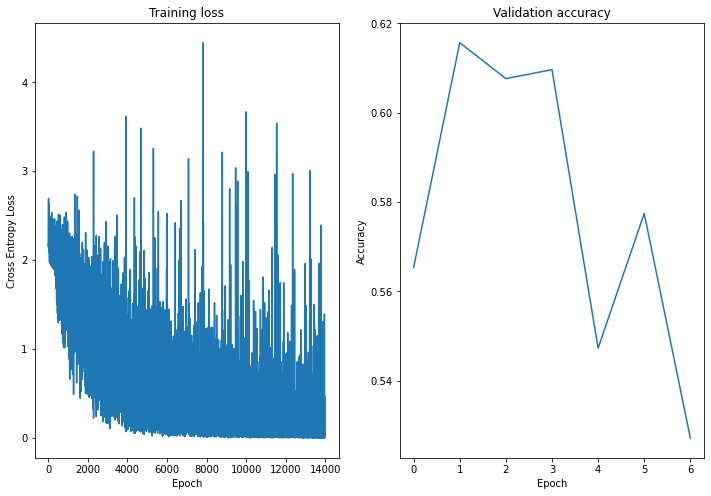

In [ ]:
num_epochs = 30
lr = 0.0001

criterion = nn.NLLLoss()

optimizer = torch.optim.Adam(rnn_model.parameters(), lr=lr)

# train the model
losses, val_acc = train(
    model=rnn_model, 
    train_dl=train_dl, 
    val_dl=dev_dl, 
    criterion=criterion, 
    optimizer=optimizer, 
    epochs=num_epochs, 
    checkpoint_name="rnn_lstm_full.pt",
    rnn=True, # for rnn
    )

# plot the training loss
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
axes[0].plot(losses)
axes[0].set_title("Training loss")
axes[0].set_ylabel("Cross Entropy Loss")
axes[0].set_xlabel("Epoch")

# plot the validation accuracy
axes[1].plot(val_acc)
axes[1].set_title("Validation accuracy")
axes[1].set_ylabel("Accuracy")
axes[1].set_xlabel("Epoch")

In [ ]:
# Load the best model from the checkpoint saved by early stopping
rnn_model.load_state_dict(torch.load('rnn_lstm_full.pt', map_location=device))

# Evaluate on Dev set
dev_preds, dev_labs = evaluate(rnn_model, dev_dl, rnn=True)
dev_preds = np.array(dev_preds)
dev_labs = np.array(dev_labs)

# Evaluate on test set
test_preds, test_labs = evaluate(rnn_model, test_dl, rnn=True)
test_preds = np.array(test_preds)
test_labs = np.array(test_labs)

accuracy = accuracy_score(test_labs, test_preds)
print("Test Accuracy (RNN): ", accuracy)

predictions["rnn"] = {"dev": dev_preds, "test": test_preds}

100%|██████████| 503/503 [02:43<00:00,  3.07it/s]

Test Accuracy (RNN):  0.6262425447316103


Text(0.5, 0.98, 'Confusion matrices for LSTM RNN')

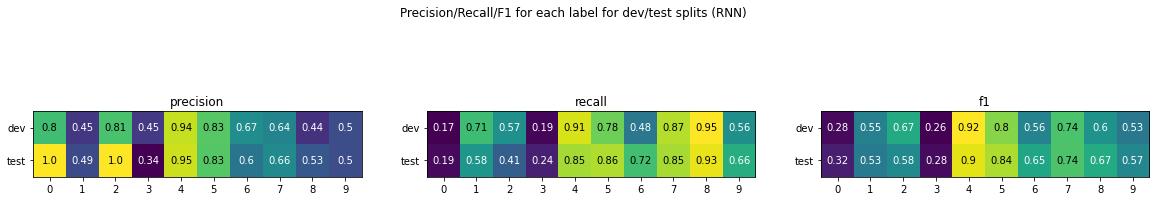

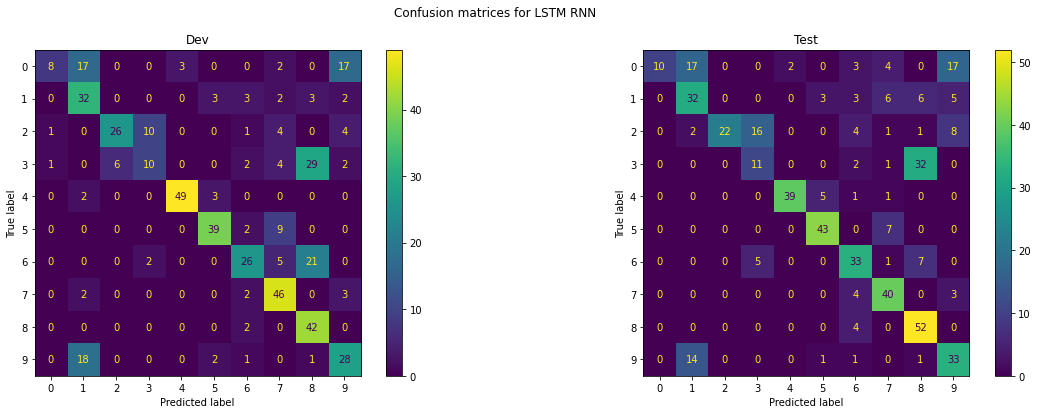

In [ ]:
dev_p, dev_r, dev_f1, dev_support = precision_recall_fscore_support(dev_labs, dev_preds, average=None)
test_p, test_r, test_f1, test_support = precision_recall_fscore_support(test_labs, test_preds, average=None)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))

dataset_labels = ["dev", "test"]
evaluation_labels = ["precision", "recall", "f1"]
stacked_precision = np.stack([dev_p, test_p])
stacked_recall = np.stack([dev_r, test_r])
stacked_f1 = np.stack([dev_f1, test_f1])
stacked_evaluations = [stacked_precision, stacked_recall, stacked_f1]
for idx, ax in enumerate(axes):
  im = ax.imshow(stacked_evaluations[idx])
  ax.set_title(evaluation_labels[idx])
  ax.set_yticks(np.arange(len(dataset_labels)), dataset_labels)
  ax.set_xticks(np.arange(10), range(10))

  for i in range(stacked_evaluations[idx].shape[0]):
    for j in range(stacked_evaluations[idx].shape[1]):
      value = np.round(stacked_evaluations[idx][i][j], 2)
      text = ax.text(j, i, value, ha="center", va="center", color="w" if value < 0.7 else "black")
fig.suptitle("Precision/Recall/F1 for each label for dev/test splits (RNN)")

# analyze the confusion matrix of the baseline 
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

ConfusionMatrixDisplay.from_predictions(dev_labels, dev_preds, labels=clf.classes_, ax=axes[0])
axes[0].set_title("Dev")

ConfusionMatrixDisplay.from_predictions(test_labels, test_preds, labels=clf.classes_, ax=axes[1])
axes[1].set_title("Test")

fig.suptitle("Confusion matrices for LSTM RNN")

### Analysis

The plot for the training loss and the validation accuracy in each epoch can be seen above. Since, we're using a batch of 1, the loss plot is quite erratic but the loss does gradually decrease. By just using a simple RNN model, we were able to almost double our test accuracy compared to our baseline. The test accuracy for the LSTM based RNN is about 63%.

Again, we plot the heatmap for the precision, recall and F1 score for both dev and test set. The scores have improved much from the baseline for precision, recall and F1. The digits 0 and 3 have somewhat low precision and recall and consequently, low F1 score.

Similarly, we plot the confusion matrix for the dev and test set for this RNN model. As we can see, it is much better than the confusion matrix for the baseline. There seems to be much less confusion between the true labels and the predictions. The high confusion rate for digit 6 has been almost eliminated. For this model, there seems to be some confusion between the true and predicted labels of digits 3 and 8 for both the dev and test set.

# Conformer

Next, we tried a transformer model, particularly the Conformer (https://arxiv.org/abs/2005.08100). It is a combination of Convolution and Transformer model. This is based on the intuition that Transformer models can handle long-term dependencies well and Convolution models can handle the local information well. Conformer was originally used in the case of speech recognition i.e. predicting the spoken text. In our implementation, we have adapted it for the case of Classification.

For this, we first tried to implement the paper ourselves and took help and code from the following implementations when we had some difficulty.

1. https://github.com/lucidrains/conformer/
2. https://github.com/sooftware/conformer/

In [27]:
class DepthWiseConv1d(nn.Module):
    # Taken from: https://github.com/lucidrains/conformer/blob/master/conformer/conformer.py
    # Depth wise convolution calculates convolution of each input channel with a different kernel
    # and concatenates it along the channel axis. In this convolution information isn't mixed
    # across different channels
    def __init__(self, chan_in, chan_out, kernel_size, padding):
        super().__init__()
        self.padding = padding
        self.conv = nn.Conv1d(chan_in, chan_out, kernel_size, groups=chan_in)

    def forward(self, x):
        x = F.pad(x, self.padding)
        return self.conv(x)

In [28]:
# simple functions used in the following classes
def exists(val):
    """Checks if value is None"""
    return val is not None

def default(val, d):
    """Returns a default value d if val doesn't exist"""
    return val if exists(val) else d

In [29]:
class RelativeSelfAttention(nn.Module):
    # Taken from: https://github.com/lucidrains/conformer/blob/master/conformer/conformer.py
    # This is same as the multi-headed self-attention but we use relative position encoding
    # to represent the positional information between the input tokens better. 
    def __init__(
        self,
        dim,
        heads = 8,
        dim_head = 64,
        max_pos_emb = 512
    ):
        super().__init__()
        inner_dim = dim_head * heads
        self.heads= heads
        self.scale = dim_head ** -0.5
        self.to_q = nn.Linear(dim, inner_dim, bias = False)
        self.to_kv = nn.Linear(dim, inner_dim * 2, bias = False)
        self.to_out = nn.Linear(inner_dim, dim)

        self.max_pos_emb = max_pos_emb

        # this embeddings stores the relativ positional information
        self.rel_pos_emb = nn.Embedding(2 * max_pos_emb + 1, dim_head)

    def forward(self, x, context = None, mask = None, context_mask = None):
        n, device, h, max_pos_emb, has_context = x.shape[-2], x.device, self.heads, self.max_pos_emb, exists(context)
        context = default(context, x)

        q, k, v = (self.to_q(x), *self.to_kv(context).chunk(2, dim = -1))
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), (q, k, v)) # rearrange using einsum operations

        # multiply queries and keys using einsum
        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        # shaw's relative positional embedding
        seq = torch.arange(n, device = device)
        dist = rearrange(seq, 'i -> i ()') - rearrange(seq, 'j -> () j')
        dist = dist.clamp(-max_pos_emb, max_pos_emb) + max_pos_emb
        rel_pos_emb = self.rel_pos_emb(dist).to(q)
        # multiply queries with relative positional encoding
        pos_attn = einsum('b h n d, n r d -> b h n r', q, rel_pos_emb) * self.scale
        dots = dots + pos_attn

        if exists(mask) or exists(context_mask):
            mask = default(mask, lambda: torch.ones(*x.shape[:2], device = device))
            context_mask = default(context_mask, mask) if not has_context else default(context_mask, lambda: torch.ones(*context.shape[:2], device = device))
            mask_value = -torch.finfo(dots.dtype).max
            mask = rearrange(mask, 'b i -> b () i ()') * rearrange(context_mask, 'b j -> b () () j')
            dots.masked_fill_(~mask, mask_value)

        attn = dots.softmax(dim = -1)

        # multiply attention scores with values using einsum operations
        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.to_out(out)
        return out

In [30]:
class MHAModule(nn.Module):
  """
  The multihead attention module of Conformer. It uses the relative self attention defined above.
  """
  def __init__(self, embeds_dim=512, n_heads=8, attn_head_dim=64, p=0.2):
    """
    param embeds_dim: size of the embeddings
    param n_heads: the number of attention heads
    param attn_head_dim: the embedding size of each attention head
    param p: the dropout probability
    """
    super(MHAModule, self).__init__()

    self.layer_norm = nn.LayerNorm(normalized_shape=embeds_dim)
    self.mha = RelativeSelfAttention(dim=embeds_dim, heads=n_heads, dim_head=attn_head_dim)
    self.dropout = nn.Dropout(p=p)

  def forward(self, x):
    out = self.layer_norm(x)
    out = self.mha(out)
    out = self.dropout(out)
    return out

In [31]:
class FeedForwardModule(nn.Module):
  """
  The feed forward module of Conformer. It uses two linear layers along with dropout, layer normalization and swish activation func.
  """
  def __init__(self, embeds_dim, expansion_factor=4, p=0.2):
    """
    param embeds_dim: the size of the embedding
    param expansion_factor: determines the size of the intermediate representation for the linear layer
    param p: the dropout probability
    """
    super(FeedForwardModule, self).__init__()

    self.layer_norm = nn.LayerNorm(normalized_shape=embeds_dim) # out: (batch, seq_len, embeds_dim)
    self.ff1 = nn.Linear(embeds_dim, embeds_dim*expansion_factor) # out: (batch, seq_len, embeds_dim * expansion_factor)
    self.swish = nn.SiLU() # out: (batch, seq_len, embeds_dim * expansion_factor)
    self.dropout1 = nn.Dropout(p=p) # out: (batch, seq_len, embeds_dim * expansion_factor)
    self.ff2 = nn.Linear(embeds_dim*expansion_factor, embeds_dim) # out: (batch, seq_len, embeds_dim)
    self.dropout2 = nn.Dropout(p=p) # out: (batch, seq_len, embeds_dim)

  def forward(self, x):
    out = self.layer_norm(x)
    out = self.ff1(out)
    out = self.swish(out)
    out = self.dropout1(out)
    out = self.ff2(out)
    out = self.dropout2(out)
    return out

In [32]:
class ConvModule(nn.Module):
  """
  The Convolution module from Conformer
  """
  def __init__(self, embeds_dim, expansion_factor=2, kernel=3, padding="same", dropout_p=0.2):
    """
    param embeds_dim: the size of the embeddings
    param expansion_factor: the multiplier for the intermediate dimension
    param kernel: the filter size
    param padding: the padding to use (only 'same' is used in this implementation)
    param dropout_p: the dropout probability
    """
    super(ConvModule, self).__init__()

    inner_dim = embeds_dim * expansion_factor

    # To maintain shape, use same padding
    if padding == "same":
      pad_size = kernel // 2
      padding = (pad_size, pad_size - (kernel+1)%2)

    self.layer_norm = nn.LayerNorm(normalized_shape=embeds_dim)
    self.rearrange1 = Rearrange('b n c -> b c n')
    self.pointwise1 = nn.Conv1d(in_channels=embeds_dim, out_channels=inner_dim*2, kernel_size=1)
    self.glu = nn.GLU(dim=1)
    self.depthwise_conv = DepthWiseConv1d(chan_in=inner_dim, chan_out=inner_dim, kernel_size=kernel, padding=padding)
    self.batch_norm = nn.BatchNorm1d(inner_dim)
    self.swish = nn.SiLU()
    self.pointwise2 = nn.Conv1d(in_channels=inner_dim, out_channels=embeds_dim, kernel_size=1)
    self.rearrange2 = Rearrange('b c n -> b n c')
    self.dropout = nn.Dropout(p=dropout_p)

  def forward(self, x):
    out = self.layer_norm(x)
    out = self.rearrange1(out)
    out = self.pointwise1(out)
    out = self.glu(out)
    out = self.depthwise_conv(out)
    out = self.batch_norm(out)
    out = self.swish(out)
    out = self.pointwise2(out)
    out = self.rearrange2(out)
    out = self.dropout(out)
    return out

In [33]:
class ConformerBlock(nn.Module):
  """
  A single Conformer block. It combines the FF, MHA and CONV modules defined previously.
  """
  def __init__(self, embeds_dim, conv_expansion_factor=2, linear_expansion_factor=4, n_heads=8, attn_head_dim=64, dropout=0.2, padding="same"):
    """
    param embeds_dim: the size of the embeddings
    param conv_expansion_factor: the multiplier for the intermediate dimension for Conv module
    param linear_expansion_factor: the multiplier for the intermediate dimension for FF module
    param n_heads: the number of attention heads
    param attn_head_dim: the embedding dimension of the attention head
    param padding: the padding to use (only 'same' is used in this implementation)
    param dropout: the dropout probability
    """
    super(ConformerBlock, self).__init__()

    self.ff_mod1 = FeedForwardModule(embeds_dim, expansion_factor=linear_expansion_factor, p=dropout)
    self.mha_mod = MHAModule(embeds_dim, n_heads, attn_head_dim, p=dropout)
    self.conv_mod = ConvModule(embeds_dim, expansion_factor=conv_expansion_factor, padding=padding)
    self.ff_mod2 = FeedForwardModule(embeds_dim, expansion_factor=linear_expansion_factor, p=dropout)
    self.layer_norm = nn.LayerNorm(normalized_shape=embeds_dim)

  def forward(self, inp):
    out = self.ff_mod1(inp)
    out_res = inp + 0.5 * out
    out = self.mha_mod(out_res)
    out_res = out_res + out
    out = self.conv_mod(out_res)
    out_res = out + out_res
    out = self.ff_mod2(out_res)
    out_res = out_res + 0.5 * out
    out = self.layer_norm(out)
    return out

In [34]:
class Conv2dSubampling(nn.Module):
    """
    Taken from: https://github.com/sooftware/conformer/blob/main/conformer/convolution.py
    Subsamples the input to 1/4th its original size by using Conv layer with stride 2 twice

    Convolutional 2D subsampling (to 1/4 length)
    Args:
        in_channels (int): Number of channels in the input image
        out_channels (int): Number of channels produced by the convolution
    Inputs: inputs
        - **inputs** (batch, time, dim): Tensor containing sequence of inputs
    Returns: outputs, output_lengths
        - **outputs** (batch, time, dim): Tensor produced by the convolution
        - **output_lengths** (batch): list of sequence output lengths
    """
    def __init__(self, in_channels, out_channels):
        super(Conv2dSubampling, self).__init__()
        self.sequential = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=2),
            nn.ReLU(),
        )

    def forward(self, inputs, input_lengths):
        outputs = self.sequential(inputs.unsqueeze(1))
        batch_size, channels, subsampled_lengths, sumsampled_dim = outputs.size()

        outputs = outputs.permute(0, 2, 1, 3)
        outputs = outputs.contiguous().view(batch_size, subsampled_lengths, channels * sumsampled_dim)

        output_lengths = input_lengths >> 2
        output_lengths -= 1

        return outputs, output_lengths

In [50]:
class ConformerClassifier(nn.Module):
  def __init__(
      self, 
      input_dim=80, 
      n_classes=10, 
      embeds_dim=512, 
      n_layers=5, 
      conv_expansion_factor=2, 
      linear_expansion_factor=4, 
      n_heads=8, 
      attn_head_dim=64, 
      dropout=0.2, 
      padding=None):
    """
    param input_dim: the size of the input vector
    param n_classes: the number of output classes
    param embeds_dim: the size of the embeddings
    param n_layers: the number of conformer blocks to use
    param conv_expansion_factor: the multiplier for the intermediate dimension for Conv module
    param linear_expansion_factor: the multiplier for the intermediate dimension for FF module
    param n_heads: the number of attention heads
    param attn_head_dim: the embedding dimension of the attention head
    param padding: the padding to use (only 'same' is used in this implementation)
    param dropout: the dropout probability
    """
    super(ConformerClassifier, self).__init__()

    self.conv_subsampler = Conv2dSubampling(in_channels=1, out_channels=embeds_dim)
    self.linear = nn.Linear(embeds_dim * (((input_dim - 1) // 2 - 1) // 2), embeds_dim)
    self.dropout = nn.Dropout(p=dropout)
    self.conformer_blocks = nn.ModuleList([
        ConformerBlock(
            embeds_dim=embeds_dim,
            conv_expansion_factor=2,
            linear_expansion_factor=4, 
            n_heads=8, 
            attn_head_dim=64, 
            dropout=0.2, 
            padding="same"
        )

        for _ in range(n_layers)
    ])
    self.linear_out = nn.Linear(embeds_dim, n_classes)


  def forward(self, inp, inp_lengths, return_logits=False):
    out, out_lengths = self.conv_subsampler(inp, inp_lengths)
    out = self.linear(out)
    out = self.dropout(out)
    for l in self.conformer_blocks:
      out = l(out)
    out = self.linear_out(out)
    out = torch.mean(out, dim=1)

    if not return_logits:
      out = F.log_softmax(out, dim=-1)
      
    return out

In [ ]:
transformer_model = ConformerClassifier(
    input_dim=80, 
    n_classes=10, 
    embeds_dim=256, 
    n_layers=2, 
    conv_expansion_factor=2, 
    linear_expansion_factor=2, 
    n_heads=4, 
    attn_head_dim=64, 
    dropout=0.2, 
    padding="same"
    ).to(device)

100%|██████████| 497/497 [00:14<00:00, 35.38it/s]


Validation loss decreased (-inf --> 0.553320).  Saving model ...
Epoch [1/30] Loss: 1.2254 Val. Acc: 0.5533


100%|██████████| 497/497 [00:09<00:00, 50.82it/s]


EarlyStopping counter: 1 out of 5
Epoch [2/30] Loss: 0.3190 Val. Acc: 0.5352


100%|██████████| 497/497 [00:11<00:00, 41.91it/s]


Validation loss decreased (0.553320 --> 0.641851).  Saving model ...
Epoch [3/30] Loss: 0.1854 Val. Acc: 0.6419


100%|██████████| 497/497 [00:10<00:00, 45.79it/s]


Validation loss decreased (0.641851 --> 0.718310).  Saving model ...
Epoch [4/30] Loss: 0.1487 Val. Acc: 0.7183


100%|██████████| 497/497 [00:11<00:00, 43.93it/s]


EarlyStopping counter: 1 out of 5
Epoch [5/30] Loss: 0.1128 Val. Acc: 0.6821


100%|██████████| 497/497 [00:12<00:00, 41.17it/s]


EarlyStopping counter: 2 out of 5
Epoch [6/30] Loss: 0.0433 Val. Acc: 0.7042


100%|██████████| 497/497 [00:10<00:00, 48.41it/s]


EarlyStopping counter: 3 out of 5
Epoch [7/30] Loss: 0.0951 Val. Acc: 0.6841


100%|██████████| 497/497 [00:12<00:00, 41.40it/s]


EarlyStopping counter: 4 out of 5
Epoch [8/30] Loss: 0.0757 Val. Acc: 0.6841


100%|██████████| 497/497 [00:10<00:00, 48.86it/s]


Validation loss decreased (0.718310 --> 0.724346).  Saving model ...
Epoch [9/30] Loss: 0.0088 Val. Acc: 0.7243


100%|██████████| 497/497 [00:11<00:00, 42.92it/s]


Validation loss decreased (0.724346 --> 0.738431).  Saving model ...
Epoch [10/30] Loss: 0.0114 Val. Acc: 0.7384


100%|██████████| 497/497 [00:11<00:00, 42.12it/s]


EarlyStopping counter: 1 out of 5
Epoch [11/30] Loss: 0.0812 Val. Acc: 0.6137


100%|██████████| 497/497 [00:10<00:00, 46.67it/s]


EarlyStopping counter: 2 out of 5
Epoch [12/30] Loss: 0.0570 Val. Acc: 0.6579


100%|██████████| 497/497 [00:15<00:00, 32.49it/s]


EarlyStopping counter: 3 out of 5
Epoch [13/30] Loss: 0.0596 Val. Acc: 0.5795


100%|██████████| 497/497 [00:16<00:00, 30.51it/s]


EarlyStopping counter: 4 out of 5
Epoch [14/30] Loss: 0.0434 Val. Acc: 0.5996


100%|██████████| 497/497 [00:11<00:00, 41.97it/s]

EarlyStopping counter: 5 out of 5
Stopping early at epoch [15/30]


Text(0.5, 0, 'Epoch')

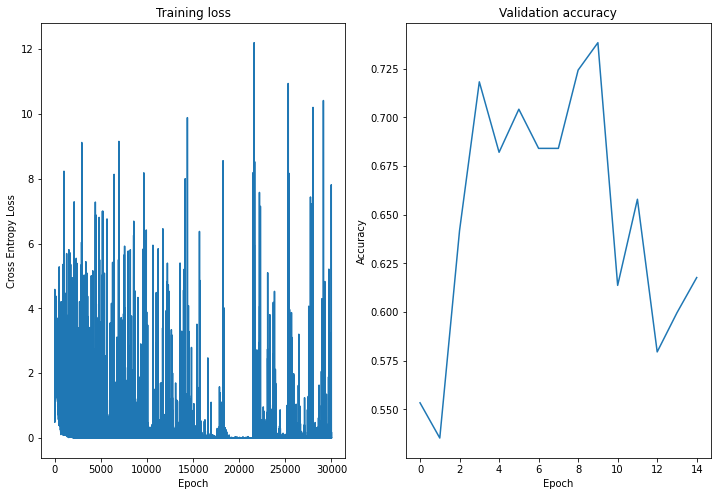

In [ ]:
num_epochs = 30
lr = 0.0001

criterion = nn.NLLLoss()

optimizer = torch.optim.Adam(transformer_model.parameters(), lr=lr)

losses, val_acc = train(
    model=transformer_model, 
    train_dl=train_dl, 
    val_dl=dev_dl, 
    criterion=criterion, 
    optimizer=optimizer, 
    epochs=num_epochs,
    checkpoint_name="conformer_full.pt"
    )

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
axes[0].plot(losses)
axes[0].set_title("Training loss")
axes[0].set_ylabel("Cross Entropy Loss")
axes[0].set_xlabel("Steps")

axes[1].plot(val_acc)
axes[1].set_title("Validation accuracy")
axes[1].set_ylabel("Accuracy")
axes[1].set_xlabel("Epoch")

In [ ]:
# Load the best model from the checkpoint saved by early stopping
transformer_model.load_state_dict(torch.load('conformer_full.pt', map_location=device))

dev_preds, dev_labs = evaluate(transformer_model, dev_dl)
dev_preds = np.array(dev_preds)
dev_labs = np.array(dev_labs)

test_preds, test_labs = evaluate(transformer_model, test_dl)
test_preds = np.array(test_preds)
test_labs = np.array(test_labs)
print("Test accuracy (Conformer): ", accuracy_score(test_labs, test_preds))
predictions["conformer"] = {"dev": dev_preds, "test": test_preds}

100%|██████████| 503/503 [00:11<00:00, 45.14it/s]

Test accuracy (Conformer):  0.805168986083499


Text(0.5, 0.98, 'Confusion matrices for Linear SGDClassifier (SVM)')

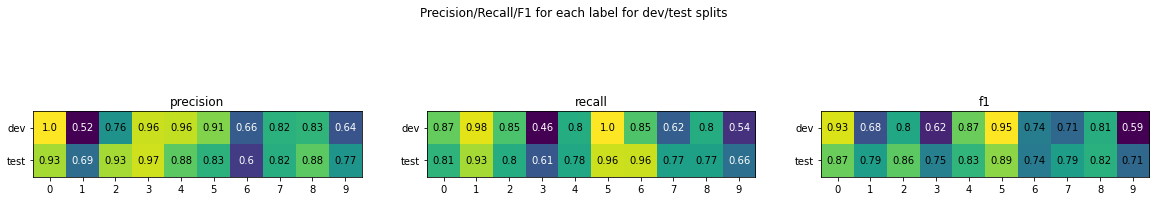

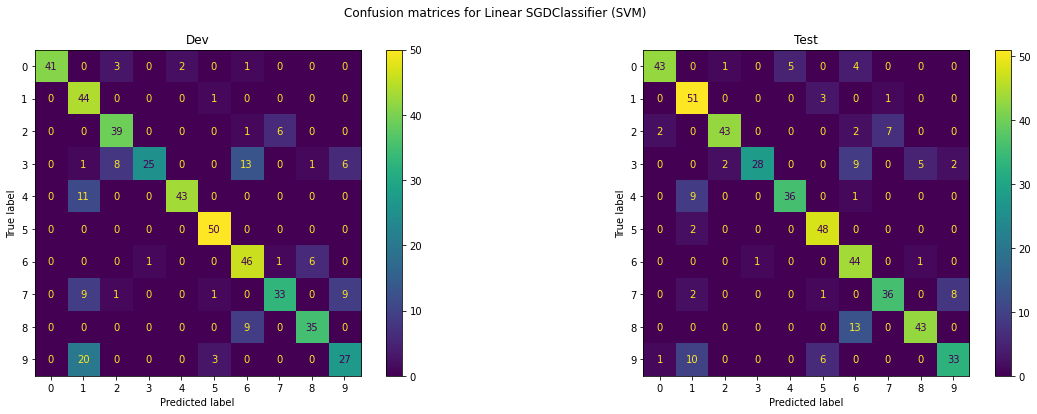

In [ ]:
dev_p, dev_r, dev_f1, dev_support = precision_recall_fscore_support(dev_labs, dev_preds, average=None)
test_p, test_r, test_f1, test_support = precision_recall_fscore_support(test_labs, test_preds, average=None)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))

dataset_labels = ["dev", "test"]
evaluation_labels = ["precision", "recall", "f1"]
stacked_precision = np.stack([dev_p, test_p])
stacked_recall = np.stack([dev_r, test_r])
stacked_f1 = np.stack([dev_f1, test_f1])
stacked_evaluations = [stacked_precision, stacked_recall, stacked_f1]
for idx, ax in enumerate(axes):
  im = ax.imshow(stacked_evaluations[idx])
  ax.set_title(evaluation_labels[idx])
  ax.set_yticks(np.arange(len(dataset_labels)), dataset_labels)
  ax.set_xticks(np.arange(10), range(10))

  for i in range(stacked_evaluations[idx].shape[0]):
    for j in range(stacked_evaluations[idx].shape[1]):
      value = np.round(stacked_evaluations[idx][i][j], 2)
      text = ax.text(j, i, value, ha="center", va="center", color="w" if value < 0.7 else "black")
fig.suptitle("Precision/Recall/F1 for each label for dev/test splits")

# analyze the confusion matrix of the baseline 
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

ConfusionMatrixDisplay.from_predictions(dev_labels, dev_preds, labels=clf.classes_, ax=axes[0])
axes[0].set_title("Dev")

ConfusionMatrixDisplay.from_predictions(test_labels, test_preds, labels=clf.classes_, ax=axes[1])
axes[1].set_title("Test")

fig.suptitle("Confusion matrices for Linear SGDClassifier (SVM)")

### Analysis

We train the Conformer model for which the training loss curve and validation accuracy plots can be seen above. Using the conformer model, we were able to improve our accuracy on the test set to about 81% which is a great improvement over the baseline.

We repeat the same evaluation steps as before by calculating the precision, recall and F1 score. With Conformer, the results seem much better with higher precision, recall and F1 scores. Digits 3 and 9 show lower F1 score due to their low recall scores.

We also plot the Confusion matrix for the dev and test set for the Conformer model. In this case, the plot seems to be more chaotic than in the RNN model. Most of the examples seem to have been classified well but there are quite a lot of confusion such as with digits 9 and 1. Similarly, the test confusion matrix seems to be better than the dev test with lower number of misclassifications. Still, 9 seems to be misclassified as 1 and 8 as 6 more than other digits.

# Hyperparameter Tuning (Gridsearch)

For hyperparameter tuning and searching (gridsearch, in our case), we used the Ray tune library which takes a search space and tries the model in every possible combinations of the hyperparameters in that search space. The search space is defined below which contains possible values for hyperparameters such as the embeddings size, number of attention heads and their embeddings dimension, dropout probability and so on. Unfortunately, due to computational constraints in Colab (and no other resource to try gridsearch and also a somewhat large search space), we weren't able to complete the hyperparameter search. The following code only shows our attempt at hyperparameter search.

In [ ]:
# Run Gridsearch for hyperparameter tuning
def objective(config):
  """
  This function is run over and over again with different hyperparameters during gridsearch
  """
  train_loader, val_loader = train_dl, dev_dl
  model = ConformerClassifier(
      input_dim=80, 
      n_classes=10, 
      embeds_dim=config["embed_size"], 
      n_layers=config["num_layers"], 
      conv_expansion_factor=config["conv_expansion_factor"], 
      linear_expansion_factor=config["linear_expansion_factor"], 
      n_heads=config["n_heads"], 
      attn_head_dim=config["heads_dim"], 
      dropout=config["dropout"], 
      padding="same"
      ).to(device)

  optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])
  criterion = nn.NLLLoss()
  while True:
    losses, val_acc = train(
        model=model, 
        train_dl=train_loader, 
        val_dl=val_loader, 
        criterion=criterion, 
        optimizer=optimizer, 
        epochs=config["n_epochs"],
        early_stop=False, # don't use early stopping
        )
    session.report({"mean_accuracy": np.mean(val_acc)})

In [ ]:
# This is where we've defined the search space for each hyperparameter
search_space = {
    "lr": tune.grid_search([0.0001, 0.001, 0.01]),
    "n_epochs": tune.grid_search([5]),
    "embed_size": tune.grid_search([128, 256, 512]),
    "num_layers": tune.grid_search([1, 2, 3]),
    "conv_expansion_factor": tune.grid_search([2, 4]),
    "linear_expansion_factor": tune.grid_search([2, 4]),
    "n_heads": tune.grid_search([4, 8, 12]),
    "heads_dim": tune.grid_search([64, 128]),
    "dropout": tune.grid_search([0.1, 0.2, 0.3])
}

In [ ]:
tuner = tune.Tuner(
    tune.with_resources(objective, resources={"cpu": 2, "gpu": 1}),
    tune_config=tune.TuneConfig(
        num_samples=10,
        scheduler=ASHAScheduler(metric="mean_accuracy", mode="max"), # select the hyperparameters based on their mean accuracy
        
    ),
    param_space=search_space,
    )
results = tuner.fit()

# TSNE

Next, we use t-SNE algorithm to reduce the dimensions of the spectrogram so that we can plot the data and see how our classification algorithms classify those points. We reduce the dimension of the spectrogram to 2 components of t-SNE which will act as the axes in our 2D plot.

In [ ]:
# Initialize t-SNE for 2 components (and other default parameters) and transform the downsampled dev/test set into 2D data
# We also tested it with different perplexity values and number of iterations but didn't find a combination that resulted in clusters
tsne = TSNE(n_components=2)
dev_tsne = tsne.fit_transform(dev_set)
test_tsne = tsne.fit_transform(test_set)

Text(0.5, 0.98, '2D TSNE plot for the SGDClassifier (SVM) with predicted labels')

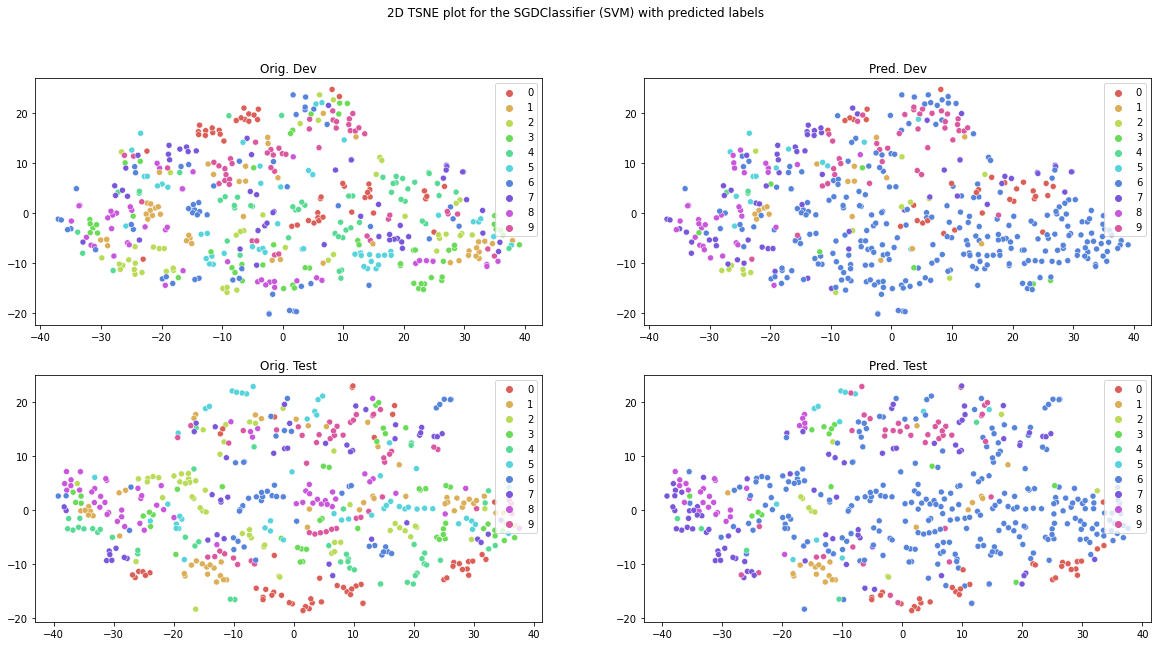

In [ ]:
# Next, we plot the 2 components and see how the baseline model classified the data points
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

sns.scatterplot(x=dev_tsne[:, 0], y=dev_tsne[:, 1], hue=dev_labs, palette=sns.hls_palette(10), legend="full", ax=axes[0][0])
axes[0][0].set_title("Orig. Dev")

sns.scatterplot(x=dev_tsne[:, 0], y=dev_tsne[:, 1], hue=predictions["svm"]["dev"], palette=sns.hls_palette(10), legend="full", ax=axes[0][1])
axes[0][1].set_title("Pred. Dev")

sns.scatterplot(x=test_tsne[:, 0], y=test_tsne[:, 1], hue=test_labs, palette=sns.hls_palette(10), legend="full", ax=axes[1][0])
axes[1][0].set_title("Orig. Test")

sns.scatterplot(x=test_tsne[:, 0], y=test_tsne[:, 1], hue=predictions["svm"]["test"], palette=sns.hls_palette(10), legend="full", ax=axes[1][1])
axes[1][1].set_title("Pred. Test")

fig.suptitle("2D TSNE plot for the SGDClassifier (SVM) with predicted labels")

### Analysis

The above plots show the t-SNE plots for each model i.e. the baseline, the RNN and the Conformer model and for the dev and test set. As we can see in the plots, there doesn't seem to be definite clusters (based on the components generated by t-SNE) of each digits so it is a bit difficult to clearly see how accurate the classifications are from the plot. Nevertheless, we can still compare regions to get an idea of the classification accuracy or the decision boundaries.

As we discussed before, in case of baseline, a lot of misclassifications were with the digit 6. This can also be seen in above plots with the blue dots in both dev and test plot. A lot of points have been classified as 6 even though they are in different classes in the original dataset.

Text(0.5, 0.98, '2D TSNE plot for the LSTM RNN with predicted labels')

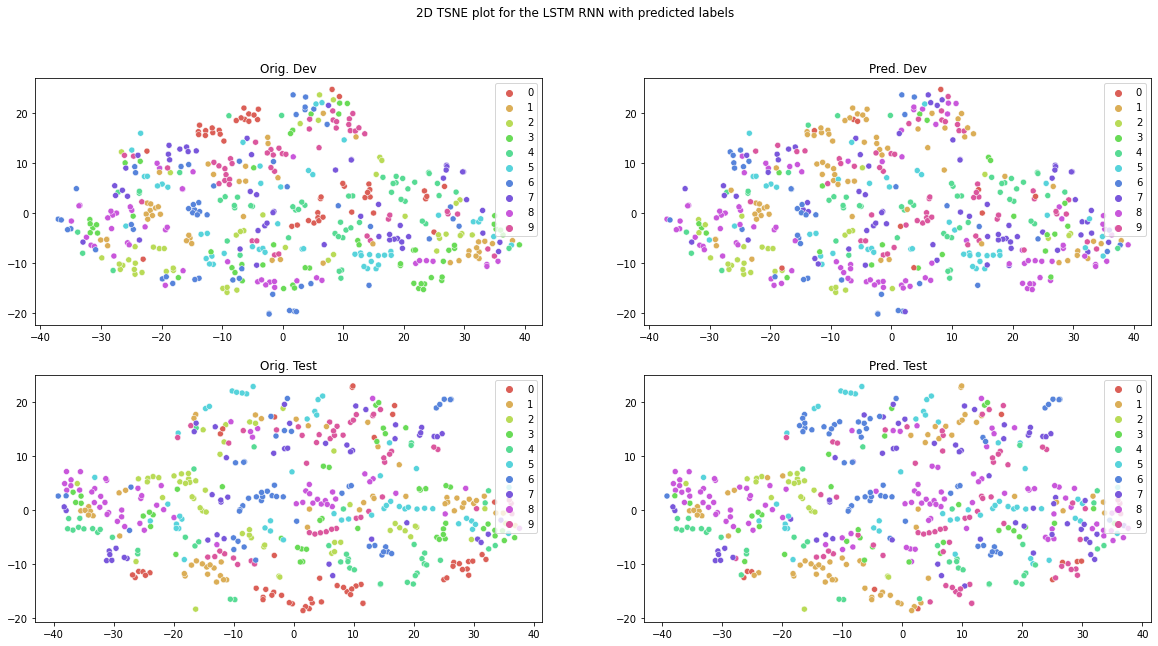

In [ ]:
# Next, we plot the 2 components and see how the RNN model classified the data points
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

sns.scatterplot(x=dev_tsne[:, 0], y=dev_tsne[:, 1], hue=dev_labs, palette=sns.hls_palette(10), legend="full", ax=axes[0][0])
axes[0][0].set_title("Orig. Dev")

sns.scatterplot(x=dev_tsne[:, 0], y=dev_tsne[:, 1], hue=predictions["rnn"]["dev"], palette=sns.hls_palette(10), legend="full", ax=axes[0][1])
axes[0][1].set_title("Pred. Dev")

sns.scatterplot(x=test_tsne[:, 0], y=test_tsne[:, 1], hue=test_labs, palette=sns.hls_palette(10), legend="full", ax=axes[1][0])
axes[1][0].set_title("Orig. Test")

sns.scatterplot(x=test_tsne[:, 0], y=test_tsne[:, 1], hue=predictions["rnn"]["test"], palette=sns.hls_palette(10), legend="full", ax=axes[1][1])
axes[1][1].set_title("Pred. Test")

fig.suptitle("2D TSNE plot for the LSTM RNN with predicted labels")

### Analysis

Similarly, when plotted for RNN, we can see that the classification seems to be better with less misclassifications as we don't see any one digit dominating the predictions like in case of baseline. Still there seems to be confusion between the digits 0 and 1 particularly in the dev set. In the case of test set, the misclassification seems to be more among 3 and 8.

Text(0.5, 0.98, '2D TSNE plot for the Conformer with predicted labels')

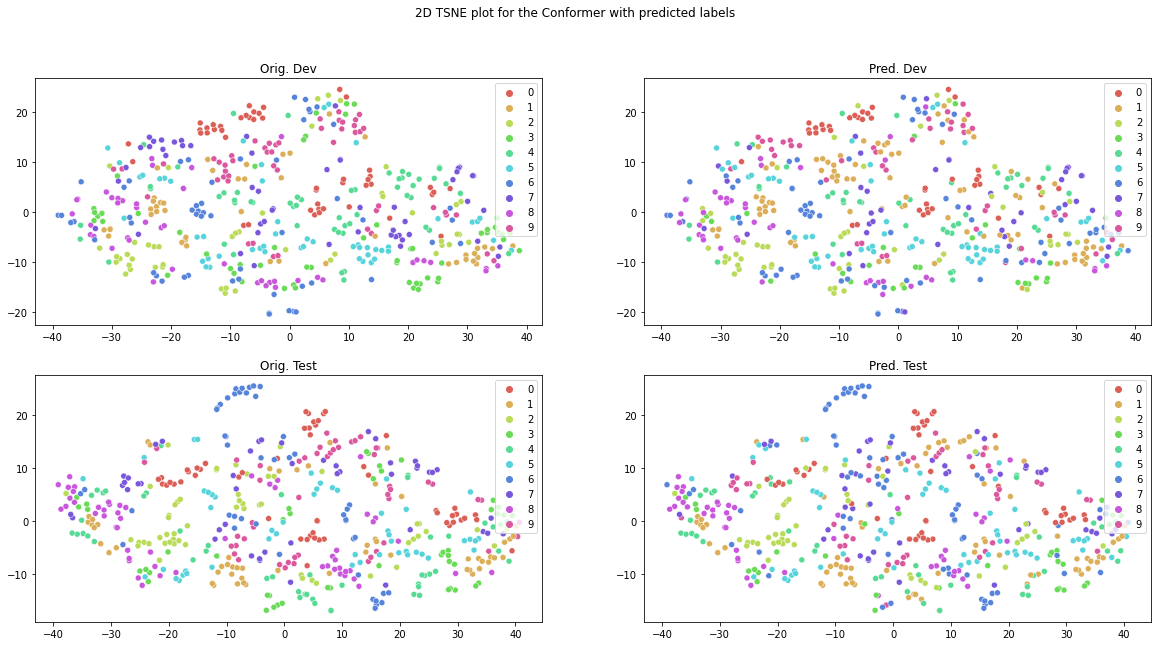

In [ ]:
# Finally, we plot the 2 components and see how the Conformer model classified the data points
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

sns.scatterplot(x=dev_tsne[:, 0], y=dev_tsne[:, 1], hue=dev_labs, palette=sns.hls_palette(10), legend="full", ax=axes[0][0])
axes[0][0].set_title("Orig. Dev")

sns.scatterplot(x=dev_tsne[:, 0], y=dev_tsne[:, 1], hue=predictions["conformer"]["dev"], palette=sns.hls_palette(10), legend="full", ax=axes[0][1])
axes[0][1].set_title("Pred. Dev")

sns.scatterplot(x=test_tsne[:, 0], y=test_tsne[:, 1], hue=test_labs, palette=sns.hls_palette(10), legend="full", ax=axes[1][0])
axes[1][0].set_title("Orig. Test")

sns.scatterplot(x=test_tsne[:, 0], y=test_tsne[:, 1], hue=predictions["conformer"]["test"], palette=sns.hls_palette(10), legend="full", ax=axes[1][1])
axes[1][1].set_title("Pred. Test")

fig.suptitle("2D TSNE plot for the Conformer with predicted labels")

### Analysis

The plot is similar to that of the RNN with less misclassification errors. The Conformer model was much more accurate than the other two so both the original plot and the predicted model for Conformer seem similar with fewer errors. As we've discussed before in the Confusion matrix section, we can see the confusion between 9 and 1 and 8 and 6 in the plots for the dev and test set above.

# Bootstrap

Now, we need to measure the statistical significance of our predictions and its accuracy on the test set. For this, we'll use the bootstrap approach. In this approach, we'll randomly sample n examples from the test set and evaluate our model on this bootstrapped set. We'll then compare it to our existing improvement in accuracy. We'll repeat this process thousands of time (suggested in paper 10^6 iterations) to get a p-value based on the bootstrap test set evaluations. If this p-value is < 0.05, we can be 95% sure that the improvement in accuracy due to our neural models are not due to chance.

In [ ]:
def calculate_bootstrap_indices(n):
  """
  Generates an array of indices randomly to be used in sampling from the dataset

  param n: the length of the dataset
  """
  indices = np.random.randint(0, n-1, n)
  return indices

In [ ]:
def run_bootstrap(model, data, labels, delta_x, baseline_acc, b_iters=1e4):
  """
  Run the bootstrap approach for measuring the statistical significance

  param model: the model to evaluate (Pytorch model instance)
  param data: the original test dataset
  param labels: the corresponding labels of the test set
  param delta_x: the improvement made by the new model over the baseline (new_acc - base_acc)
  param baseline_acc: the baseline accuracy for comparing with the bootstrap accuracy
  param b_iters: the number of bootstrap iterations to run
  """
  dataset_size = len(data)

  # standard error
  s = 0.0
  acc_sum = 0.0

  if not isinstance(data, np.ndarray):
    data = np.array(data)
    labels = np.array(labels)

  for i in tqdm(range(b_iters), position=0, leave=True):
    # calculate the bootstrap indices
    indices = calculate_bootstrap_indices(dataset_size)

    # sample based on the indices
    bootstrap_dataset = data[indices]
    bootstrap_labels = labels[indices]

    # create a bootstrap dataset
    bootstrap_dataset = AudioDataset(bootstrap_dataset, bootstrap_labels)
    bootstrap_dl = DataLoader(bootstrap_dataset, batch_size=1, shuffle=False)

    # evaluate the model on this bootstrap dataset
    bootstrap_preds, bootstrap_labels = evaluate(model, bootstrap_dl, disable_progress=True)
    bootstrap_preds = np.array(bootstrap_preds)
    bootstrap_labels = np.array(bootstrap_labels)

    # calculate the accuracy for the bootstrap predictions
    bootstrap_acc = accuracy_score(bootstrap_labels, bootstrap_preds)
    acc_sum += bootstrap_acc

    # calculate bootstrap delta value
    bootstrap_delta = bootstrap_acc - baseline_acc

    # if bootstrap_delta is larger than twice our model delta, we update s
    if bootstrap_delta > 2 * delta_x:
      s += 1.0

    if i % 500 == 0:
      pickle.dump({"s": s, "acc": acc_sum, "b_iters": i}, open(data_dir + "bootstrap_result.pkl", "wb"))

  # calculate p-value
  p_value = np.divide(s, b_iters)

  # calculate average test accuracy
  average_acc = np.divide(acc_sum, b_iters)

  return p_value, average_acc

In [ ]:
# conformer accuracy (test) - svm accuracy (test)
delta_x = 0.81 - 0.36

p_value, average_acc = run_bootstrap(transformer_model, test_files, test_labels, delta_x, baseline_acc=36.0, b_iters=10**4)

In [ ]:
# these were saved in the google drive after each 500 iterations
# the following result is after 2500 iterations
#
# bootstrap_results = pickle.load(open(data_dir + "bootstrap_result.pkl", "rb"))
# bootstrap_results

{'s': 0.0, 'acc': 2010.6819085486927, 'b_iters': 2500}

### Analysis

Due to computational constraints on Colab, we couldn't run the bootstrap evaluation to a sufficiently large number of iterations. Although the recommended number of iterations (in the paper) was 10^6 iterations, the above results shows the standard error and the average accuracy for 2500 iterations for the Conformer model. While this number of iterations is not enough to concretely say that the improvement is statistically significant, for the 2500 iterations the standard error is zero and the average accuracy for each bootstrap run seems to be around 80% (similar to the test accuracy of Conformer model) which suggests that the improvement might be statistically significant.

## Task III (Open Ended)
1. Consider the case where we have speech data from a single speaker (e.g., george). Train your models on this subset of the data. What do you observe? How does this affect the model performance? 

2. Even though a model is trained on a single speaker, we would like the model to generalizes to any speaker. To this end, one can use data augmentation techniques to artificially create more samples for each class. Some of these augmentations can be applied on the spectrogram (e.g., SpecAugment https://ai.googleblog.com/2019/04/specaugment-new-data-augmentation.html), and other can be applied on the raw waveform before creating the spectrogram such as pitch manipulation (https://github.com/facebookresearch/WavAugment). Explore the effect of one type of augmentation from each type. Report your observation and anaylze the confusion matrices.

3. Data augmentation techniques create different "views" of each training sample in a stochastic or determinstic approach. One can leaverage speech data augmentation to create views for training a neural network in a contrastive learning setting with margin-based objective function (for more info, read http://proceedings.mlr.press/v130/al-tahan21a/al-tahan21a.pdf). Implement at least one model using a contrastive loss based on different views of the training samples. Does this model improve over the model without contrastive learning? Report and discuss your observations. 

For more information on the contrastive learning framework, you can refer to this paper
https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9226466

In [ ]:
# speakers = {'george', 'jackson', 'lucas', 'nicolas', 'theo', 'yweweler'}
# let's train only on george's data and evaluate on original dev/test set

sdr_df_george = sdr_df[sdr_df.speaker == "george"]

train_files = sdr_df_george.file[sdr_df_george.split == "TRAIN"].tolist()
dev_files = sdr_df.file[sdr_df.split == "DEV"].tolist()
test_files = sdr_df.file[sdr_df.split == "TEST"].tolist()

train_labels = sdr_df_george.label[sdr_df_george.split == "TRAIN"].tolist()
dev_labels = sdr_df.label[sdr_df.split == "DEV"].tolist()
test_labels = sdr_df.label[sdr_df.split == "TEST"].tolist()

In [ ]:
# check the number of examples in each set
len(train_files), len(dev_files), len(test_files)

(500, 497, 503)

In [ ]:
train_ds = AudioDataset(train_files, train_labels)
dev_ds = AudioDataset(dev_files, dev_labels)
test_ds = AudioDataset(test_files, test_labels)

train_dl = DataLoader(train_ds, batch_size=1, shuffle=True)
dev_dl = DataLoader(dev_ds, batch_size=1, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=False)

100%|██████████| 497/497 [00:10<00:00, 47.19it/s]


Validation loss decreased (-inf --> 0.167002).  Saving model ...
Epoch [1/30] Loss: 1.6523 Val. Acc: 0.1670


100%|██████████| 497/497 [00:09<00:00, 51.72it/s]


Validation loss decreased (0.167002 --> 0.255533).  Saving model ...
Epoch [2/30] Loss: 0.4543 Val. Acc: 0.2555


100%|██████████| 497/497 [00:11<00:00, 44.34it/s]


Validation loss decreased (0.255533 --> 0.271630).  Saving model ...
Epoch [3/30] Loss: 0.1137 Val. Acc: 0.2716


100%|██████████| 497/497 [00:11<00:00, 43.70it/s]


EarlyStopping counter: 1 out of 5
Epoch [4/30] Loss: 0.0898 Val. Acc: 0.1368


100%|██████████| 497/497 [00:21<00:00, 23.42it/s]


EarlyStopping counter: 2 out of 5
Epoch [5/30] Loss: 0.2487 Val. Acc: 0.1549


100%|██████████| 497/497 [00:13<00:00, 36.65it/s]


EarlyStopping counter: 3 out of 5
Epoch [6/30] Loss: 0.0356 Val. Acc: 0.1509


100%|██████████| 497/497 [00:14<00:00, 34.08it/s]


EarlyStopping counter: 4 out of 5
Epoch [7/30] Loss: 0.0125 Val. Acc: 0.1891


100%|██████████| 497/497 [00:13<00:00, 36.15it/s]

EarlyStopping counter: 5 out of 5
Stopping early at epoch [8/30]


Text(0.5, 0, 'Epoch')

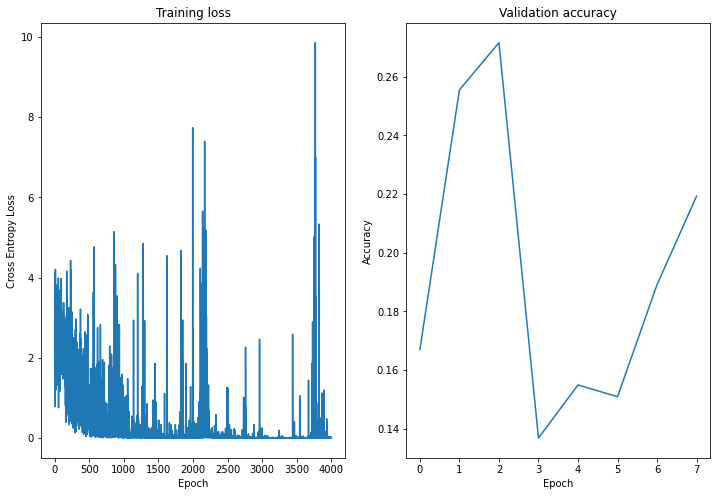

In [ ]:
# let's train on george's data
num_epochs = 30
lr = 0.0001

criterion = nn.NLLLoss()

# we're using the same architecture as before
model = ConformerClassifier(
    input_dim=80, 
    n_classes=10, 
    embeds_dim=256, 
    n_layers=2, 
    conv_expansion_factor=2, 
    linear_expansion_factor=2, 
    n_heads=4, 
    attn_head_dim=64, 
    dropout=0.2, 
    padding="same"
    ).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

losses, val_acc = train(
    model=model, 
    train_dl=train_dl, 
    val_dl=dev_dl, 
    criterion=criterion, 
    optimizer=optimizer, 
    epochs=num_epochs, 
    checkpoint_name="checkpoint_george.pt"
    )

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
axes[0].plot(losses)
axes[0].set_title("Training loss")
axes[0].set_ylabel("Cross Entropy Loss")
axes[0].set_xlabel("Epoch")

axes[1].plot(val_acc)
axes[1].set_title("Validation accuracy")
axes[1].set_ylabel("Accuracy")
axes[1].set_xlabel("Epoch")

In [ ]:
model.load_state_dict(torch.load('checkpoint_george.pt'))
test_preds, test_labs = evaluate(model, test_dl)
test_preds = np.array(test_preds)
test_labs = np.array(test_labs)
print("Test accuracy (george): ", accuracy_score(test_labs, test_preds))

100%|██████████| 503/503 [00:15<00:00, 32.85it/s]

Test accuracy (george):  0.2644135188866799


### Analysis
Here, we trained the Conformer model on only one of the speakers (George). Thus, the training set only had 500 examples to train from and the evaluations were made on the original dev and test set. In this case, the test set accuracy is only 26%. This is because we have a smaller dataset and also possibly due to the lack of variety in the training set since we are training only on a single speaker.

# Using data augmentations

## SpecAugment

Here, we've used SpecAugment approach of data augmentation for Audio. This approach augments the mel spectrogram directly so we can use the already transformed waveforms. This is applied to george's audio data and we've augmented george's data to generate 1500 more examples for a total of 2000 examples of training. We use the same model architecture for training and the results are below.

In [ ]:
# filter only george's data
sdr_df_george = sdr_df[sdr_df.speaker == "george"]

train_files = sdr_df_george.file[sdr_df_george.split == "TRAIN"].tolist()
train_labels = sdr_df_george.label[sdr_df_george.split == "TRAIN"].tolist()

In [ ]:
import torchaudio.transforms as T

stretch_rate = 1.1
time_mask_param = 80
freq_mask_param = 80

melspec_transform = T.MFCC(
        sample_rate=8000,
        n_mfcc=80,
        melkwargs={
            "n_fft": 200,
            "n_mels": 80,
            "hop_length": 80,
            "mel_scale": "htk"
        })

# time stretch transform in SpecAugment
time_stretch = T.TimeStretch(n_freq=80, fixed_rate=stretch_rate)

# time mask transform in SpecAugment
time_mask = T.TimeMasking(time_mask_param)

# frequency mask transform in SpecAugment
freq_mask = T.FrequencyMasking(freq_mask_param)

In [ ]:
# We extract the mel spectrograms for each example
george_melspectrograms = [melspec_transform(torchaudio.load(train_files[idx])[0]) for idx in range(len(train_files))]

In [ ]:
# this is the train dataset size before augmentation
len(george_melspectrograms), len(train_labels)

(500, 500)

In [ ]:
augmented_waves = []
augmented_labels = []

In [ ]:
for idx, mel in enumerate(tqdm(george_melspectrograms)):
  # augmented_mel = mel.permute(0, 2, 1)

  # apply the time mask augmentation
  augmented_mel = time_mask(mel)

  # apply the frequency mask augmentation
  augmented_mel = freq_mask(augmented_mel)

  augmented_waves.append(augmented_mel)
  augmented_labels.append(train_labels[idx])

100%|██████████| 500/500 [00:00<00:00, 3345.27it/s]


In [ ]:
# add the original training data of george to the augmented data list
augmented_waves.extend([t for t in george_melspectrograms])
augmented_labels.extend(train_labels)

In [ ]:
# after augmentation training set size
len(augmented_waves), len(augmented_labels)

(2000, 2000)

In [ ]:
class AudioDatasetFromMelSpecs(Dataset):
  """
  This is a dataset class created for handling the SpecAugment augmented waveforms
  """
  def __init__(self, mel_specs, labels):
    self.mel_specs = mel_specs
    self.labels = labels

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    wv = self.mel_specs[idx]
    wv = wv.permute(0, 2, 1)
    return (wv, wv.shape[1], self.labels[idx])

In [ ]:
augmented_george_train_ds = AudioDatasetFromMelSpecs(augmented_waves, augmented_labels)
augmented_george_train_dl = DataLoader(augmented_george_train_ds, batch_size=1, shuffle=True)

100%|██████████| 497/497 [00:11<00:00, 43.05it/s]


Validation loss decreased (-inf --> 0.229376).  Saving model ...
Epoch [1/30] Loss: 1.9660 Val. Acc: 0.2294


100%|██████████| 497/497 [00:11<00:00, 44.11it/s]


Validation loss decreased (0.229376 --> 0.313883).  Saving model ...
Epoch [2/30] Loss: 1.4847 Val. Acc: 0.3139


100%|██████████| 497/497 [00:11<00:00, 43.91it/s]


EarlyStopping counter: 1 out of 5
Epoch [3/30] Loss: 1.2834 Val. Acc: 0.2938


100%|██████████| 497/497 [00:11<00:00, 42.42it/s]


Validation loss decreased (0.313883 --> 0.376258).  Saving model ...
Epoch [4/30] Loss: 1.1862 Val. Acc: 0.3763


100%|██████████| 497/497 [00:11<00:00, 44.75it/s]


EarlyStopping counter: 1 out of 5
Epoch [5/30] Loss: 1.1509 Val. Acc: 0.3622


100%|██████████| 497/497 [00:11<00:00, 43.99it/s]


EarlyStopping counter: 2 out of 5
Epoch [6/30] Loss: 1.0806 Val. Acc: 0.2495


100%|██████████| 497/497 [00:10<00:00, 49.31it/s]


EarlyStopping counter: 3 out of 5
Epoch [7/30] Loss: 1.0531 Val. Acc: 0.3441


100%|██████████| 497/497 [00:11<00:00, 43.56it/s]


EarlyStopping counter: 4 out of 5
Epoch [8/30] Loss: 0.9986 Val. Acc: 0.2495


100%|██████████| 497/497 [00:11<00:00, 43.02it/s]

EarlyStopping counter: 5 out of 5
Stopping early at epoch [9/30]


Text(0.5, 0, 'Epoch')

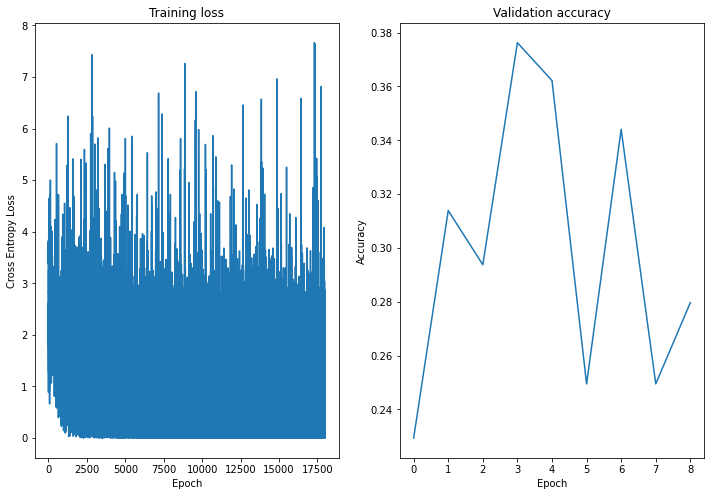

In [ ]:
# let's train on george's augmented data
num_epochs = 30
lr = 0.0001

criterion = nn.NLLLoss()

# using the same model architecture
model = ConformerClassifier(
    input_dim=80, 
    n_classes=10, 
    embeds_dim=256, 
    n_layers=2, 
    conv_expansion_factor=2, 
    linear_expansion_factor=2, 
    n_heads=4, 
    attn_head_dim=64, 
    dropout=0.2, 
    padding="same"
    ).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

losses, val_acc = train(
    model=model, 
    train_dl=augmented_george_train_dl, 
    val_dl=dev_dl, 
    criterion=criterion, 
    optimizer=optimizer, 
    epochs=num_epochs, 
    checkpoint_name="george_specaugment_checkpoint.pt"
    )

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
axes[0].plot(losses)
axes[0].set_title("Training loss")
axes[0].set_ylabel("Cross Entropy Loss")
axes[0].set_xlabel("Epoch")

axes[1].plot(val_acc)
axes[1].set_title("Validation accuracy")
axes[1].set_ylabel("Accuracy")
axes[1].set_xlabel("Epoch")

In [ ]:
model.load_state_dict(torch.load('george_specaugment_checkpoint.pt'))
test_preds, test_labs = evaluate(model, test_dl)
test_preds = np.array(test_preds)
test_labs = np.array(test_labs)
print("Test accuracy (george, specaugment): ", accuracy_score(test_labs, test_preds))

100%|██████████| 503/503 [00:16<00:00, 30.64it/s]

Test accuracy (george, specaugment):  0.4194831013916501


Text(0.5, 1.0, 'Confusion matrices for Conformer (using SpecAugment)')

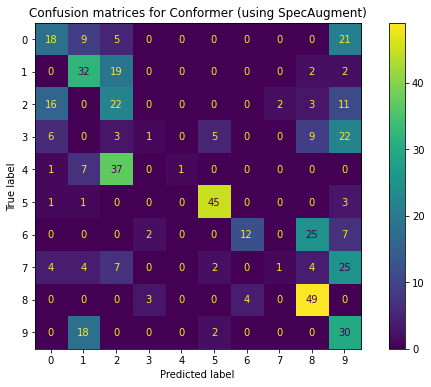

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

ConfusionMatrixDisplay.from_predictions(test_labels, test_preds, labels=clf.classes_, ax=ax)
ax.set_title("Confusion matrices for Conformer (using SpecAugment)")

### Analysis

Using SpecAugment, we were able to generate 1500 new examples which were used in training. We only used the time mask and the frequency mask augmentations. We used the same architecture of Conformer and were able to obtain about 42% accuracy on the test set which is about 16 points increase from training only on george's data without augmentation. This shows that data augmentation is effective when we have low training data. The above confusion matrix shows the classification errors. This model seems to confuse the almost all the digits with mostly 9. The model seems accurate for the digits 5 and 8 based on the confusion matrix but it has problems with other digits.

## Wavaugment

Next, we use the WavAugment audio data augmentation technique which directly augments the raw waveform. Thus, in this case we can use the raw waveforms without extracting the mfcc from it. The training process is the same as that of SpecAugment.

In [ ]:
# first install some necessary packages
! apt-get install libsox-fmt-all libsox-dev sox > /dev/null
! python -m pip install git+https://github.com/facebookresearch/WavAugment.git > /dev/null

  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/WavAugment.git /tmp/pip-req-build-f6l0n_ta


In [ ]:
import augment

In [ ]:
# filter george's data
sdr_df_george = sdr_df[sdr_df.speaker == "george"]

train_files = sdr_df_george.file[sdr_df_george.split == "TRAIN"].tolist()
train_labels = sdr_df_george.label[sdr_df_george.split == "TRAIN"].tolist()

In [ ]:
# extract the raw waveforms, not the mfcc
raw_waveforms = [torchaudio.load(x)[0] for x in train_files]
sr = 8000

In [ ]:
augmented_waveforms = []
augmented_labels = []

In [ ]:
# generate 500 pitch down augmentations
for raw_wv in raw_waveforms:
  aug_wv = augment.EffectChain().pitch(-200).rate(sr).apply(raw_wv, src_info={'rate': sr})
  augmented_waveforms.append(aug_wv)
augmented_labels.extend(train_labels)

In [ ]:
# generate 500 pitch up augmentations
for raw_wv in raw_waveforms:
  aug_wv = augment.EffectChain().pitch(200).rate(sr).apply(raw_wv, src_info={'rate': sr})
  augmented_waveforms.append(aug_wv)
augmented_labels.extend(train_labels)

In [ ]:
# generate 500 reverb augmentations
for raw_wv in raw_waveforms:
  aug_wv = augment.EffectChain().reverb(50, 50, 50).channels(1).apply(raw_wv, src_info={'rate': sr})
  augmented_waveforms.append(aug_wv)
augmented_labels.extend(train_labels)

In [ ]:
# add the original waveforms to the full dataset
augmented_waveforms.extend(raw_waveforms)
augmented_labels.extend(train_labels)

In [ ]:
# final dataset size after augmentation
len(augmented_waveforms), len(augmented_labels)

(2000, 2000)

In [ ]:
class AudioDatasetByWaveforms(Dataset):
  """
  The Pytorch dataset class for handling raw waveforms directly
  """
  def __init__(self, raw_waveforms, labels, n_mfcc=80, n_fft=200, hop_length=80, transforms=None, sr=8000):
    self.waveforms = raw_waveforms
    self.labels = labels
    self.sr = sr

    if transforms:
      self.transforms = transforms
    else:
      self.transforms = torchaudio.transforms.MFCC(
        sample_rate=self.sr,
        n_mfcc=n_mfcc,
        melkwargs={
            "n_fft": n_fft,
            "n_mels": n_mfcc,
            "hop_length": hop_length,
            "mel_scale": "htk"
        })

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    wv = self.waveforms[idx]
    wv = self.transforms(wv)
    wv = wv.permute(0, 2, 1)
    return (wv, wv.shape[1], self.labels[idx])

In [ ]:
augmented_george_train_ds = AudioDatasetByWaveforms(augmented_waveforms, augmented_labels)
augmented_george_train_dl = DataLoader(augmented_george_train_ds, batch_size=1, shuffle=True)

100%|██████████| 497/497 [00:10<00:00, 48.21it/s]


Validation loss decreased (-inf --> 0.148893).  Saving model ...
Epoch [1/30] Loss: 0.7738 Val. Acc: 0.1489


100%|██████████| 497/497 [00:13<00:00, 38.15it/s]


Validation loss decreased (0.148893 --> 0.217304).  Saving model ...
Epoch [2/30] Loss: 0.1623 Val. Acc: 0.2173


100%|██████████| 497/497 [00:11<00:00, 42.43it/s]


Validation loss decreased (0.217304 --> 0.317907).  Saving model ...
Epoch [3/30] Loss: 0.0930 Val. Acc: 0.3179


100%|██████████| 497/497 [00:11<00:00, 41.54it/s]


EarlyStopping counter: 1 out of 5
Epoch [4/30] Loss: 0.0994 Val. Acc: 0.1187


100%|██████████| 497/497 [00:11<00:00, 44.13it/s]


EarlyStopping counter: 2 out of 5
Epoch [5/30] Loss: 0.0704 Val. Acc: 0.1730


100%|██████████| 497/497 [00:09<00:00, 49.82it/s]


EarlyStopping counter: 3 out of 5
Epoch [6/30] Loss: 0.0654 Val. Acc: 0.1911


100%|██████████| 497/497 [00:11<00:00, 43.89it/s]


EarlyStopping counter: 4 out of 5
Epoch [7/30] Loss: 0.0430 Val. Acc: 0.2233


100%|██████████| 497/497 [00:11<00:00, 44.10it/s]

EarlyStopping counter: 5 out of 5
Stopping early at epoch [8/30]


Text(0.5, 0, 'Epoch')

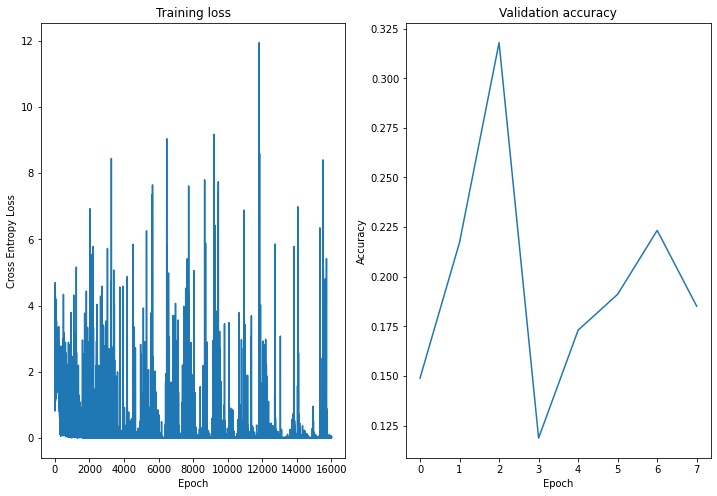

In [ ]:
# let's train on george's augmented data
num_epochs = 30
lr = 0.0001

criterion = nn.NLLLoss()

# same conformer architecture as before
model = ConformerClassifier(
    input_dim=80, 
    n_classes=10, 
    embeds_dim=256, 
    n_layers=2, 
    conv_expansion_factor=2, 
    linear_expansion_factor=2, 
    n_heads=4, 
    attn_head_dim=64, 
    dropout=0.2, 
    padding="same",
    ).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

losses, val_acc = train(
    model=model, 
    train_dl=augmented_george_train_dl, 
    val_dl=dev_dl, 
    criterion=criterion, 
    optimizer=optimizer, 
    epochs=num_epochs,
    checkpoint_name="george_wavaugment.pt"
    )

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
axes[0].plot(losses)
axes[0].set_title("Training loss")
axes[0].set_ylabel("Cross Entropy Loss")
axes[0].set_xlabel("Epoch")

axes[1].plot(val_acc)
axes[1].set_title("Validation accuracy")
axes[1].set_ylabel("Accuracy")
axes[1].set_xlabel("Epoch")

In [ ]:
model.load_state_dict(torch.load('george_wavaugment.pt'))
test_preds, test_labs = evaluate(model, test_dl)
test_preds = np.array(test_preds)
test_labs = np.array(test_labs)
accuracy_score(test_labs, test_preds)

100%|██████████| 503/503 [00:19<00:00, 26.35it/s]


0.3717693836978131

Text(0.5, 1.0, 'Confusion matrices for Conformer (using Wavaugment)')

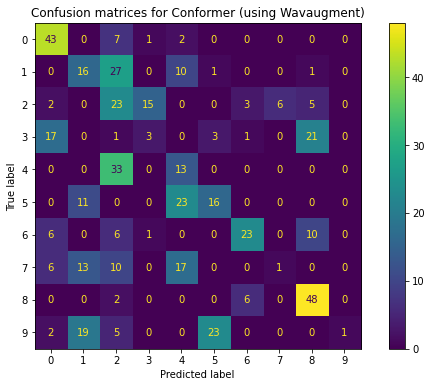

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

ConfusionMatrixDisplay.from_predictions(test_labels, test_preds, labels=clf.classes_, ax=ax)
ax.set_title("Confusion matrices for Conformer (using Wavaugment)")

### Analysis

We used WavAugment for augmenting the raw waveforms directly. We generated 500 examples each with pitch up, pitch down and reverberation. Then the total 2000 examples were used for training. Using WavAugment, we were able to get about 37% accuracy which is less than SpecAugment but still 11 points ahead from the no augmentation model. The confusion matrix shows that this model has made more misclassification mistakes than the SpecAugment one. The model seems to have problem classifying particularly 3, 7 and 9.

# Contrastive Learning

Since SpecAugment performed better than WavAugment, we will use contrastive loss learning with this augmentation technique. In supervised learning setting, contrastive loss is added to the crossentropy loss and then backpropagated. 

In [36]:
# filter only george's data
sdr_df_george = sdr_df[sdr_df.speaker == "george"]

train_files = sdr_df_george.file[sdr_df_george.split == "TRAIN"].tolist()
train_labels = sdr_df_george.label[sdr_df_george.split == "TRAIN"].tolist()

In [37]:
import torchaudio.transforms as T

stretch_rate = 1.1
time_mask_param = 80
freq_mask_param = 80

melspec_transform = T.MFCC(
        sample_rate=8000,
        n_mfcc=80,
        melkwargs={
            "n_fft": 200,
            "n_mels": 80,
            "hop_length": 80,
            "mel_scale": "htk"
        })

# time stretch transform in SpecAugment
time_stretch = T.TimeStretch(n_freq=80, fixed_rate=stretch_rate)

# time mask transform in SpecAugment
time_mask = T.TimeMasking(time_mask_param)

# frequency mask transform in SpecAugment
freq_mask = T.FrequencyMasking(freq_mask_param)

In [38]:
# We extract the mel spectrograms for each example
george_melspectrograms = [melspec_transform(torchaudio.load(train_files[idx])[0]) for idx in range(len(train_files))]

In [39]:
# this is the train dataset size before augmentation
len(george_melspectrograms), len(train_labels)

(500, 500)

In [40]:
augmented_waves = []
augmented_labels = []
for idx, mel in enumerate(tqdm(george_melspectrograms)):
  # augmented_mel = mel.permute(0, 2, 1)

  # apply the time mask augmentation
  augmented_mel = time_mask(mel)

  # apply the frequency mask augmentation
  augmented_mel = freq_mask(augmented_mel)

  augmented_waves.append(augmented_mel)
  augmented_labels.append(train_labels[idx])

100%|██████████| 500/500 [00:00<00:00, 1279.09it/s]


In [41]:
# We store a pair of (original, augmented) waves
# thus there are 500 original and 500 augmented examples
len(augmented_waves), len(augmented_labels)

(500, 500)

In [42]:
class AudioPairDatasetFromMelSpecs(Dataset):
  """
  This is a dataset class created for handling pairs of SpecAugment augmented waveforms
  The pair is formed from one of the gold example and an augmented example
  """
  def __init__(self, mel_specs, aug_mel_specs, labels):
    self.gold_mel_specs = mel_specs
    self.aug_mel_specs = aug_mel_specs
    self.labels = labels

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    gold_wv = self.gold_mel_specs[idx]
    gold_wv = gold_wv.permute(0, 2, 1)

    aug_wv = self.aug_mel_specs[idx]
    aug_wv = aug_wv.permute(0, 2, 1)

    return (gold_wv, gold_wv.shape[1], aug_wv, aug_wv.shape[1], self.labels[idx])

In [43]:
audio_pairs_dataset = AudioPairDatasetFromMelSpecs(mel_specs=george_melspectrograms, aug_mel_specs=augmented_waves, labels=train_labels)
aug_pair_george_train_dl = DataLoader(audio_pairs_dataset, batch_size=1, shuffle=True)

In [44]:
# Calculate the Contrastive loss
# Adapted from: https://github.com/haideraltahan/CLAR/blob/main/utils.py 

def nt_xent_loss(out_1, out_2, temperature=0.5):
    """
    Loss used in SimCLR
    """
    out = torch.cat([out_1, out_2], dim=0)
    n_samples = len(out)

    # Full similarity matrix
    cov = torch.mm(out, out.t().contiguous())
    sim = torch.exp(cov / temperature)

    # Negative similarity
    mask = ~torch.eye(n_samples, device=sim.device).bool()
    neg = sim.masked_select(mask).view(n_samples, -1).sum(dim=-1)

    # Positive similarity :
    pos = torch.exp(torch.sum(out_1 * out_2, dim=-1) / temperature)
    pos = torch.cat([pos, pos], dim=0)
    loss = -torch.log(pos / neg).mean()

    return loss

In [45]:
def shared_step(y_hat1, y_hat2, y):
  """
  Calculates the contrastive loss during training

  param y_hat1: raw logits of original wave
  param y_hat2: raw logits of augmented wave
  param y: gold label
  """
  y_hat1 = F.normalize(y_hat1, dim=1)
  y_hat2 = F.normalize(y_hat2, dim=1)

  sm_y_hat1 = F.log_softmax(y_hat1)
  sm_y_hat2 = F.log_softmax(y_hat2)

  label_loss = F.nll_loss(sm_y_hat1, y) + F.nll_loss(sm_y_hat2, y)
  loss = nt_xent_loss(y_hat1, y_hat2) + label_loss

  if torch.isnan(loss):
    print("smyh1:", sm_y_hat1, "smh2:", sm_y_hat2, "yh1:", y_hat1, "yh2:", y_hat2)
  return loss

In [46]:
def train_CL(model, train_dl, val_dl, criterion, optimizer, epochs=5, early_stop=True, patience=5, checkpoint_name="checkpoint.pt", rnn=False):
    """
    Train the model on the given data

    param model: the instance of Pytorch NN model
    param train_dl: the training dataloader to be trained on
    param val_dl: the validation dataloader for evaluating (in training and in early stopping)
    param criterion: the loss function
    param optimizer: the optimizer function
    param epochs: the number of epochs to train the model for
    param early_stop: If the early stopping should be used or not
    param patience: (for early stopping) the number of times to wait before stopping training
    param checkpoint_name: (for early stopping) the name of the model checkpoint
    """
    losses_to_plot = []
    validation_accuracy = []

    # initialize the earlystopping module
    early_stopping = EarlyStopping(patience=patience, verbose=True, path=checkpoint_name)

    for epoch in range(epochs):
        epoch_loss = []
        #initialize pairs to calcuclate CL losses
        pair = {}
        for i, (inp_wave, inp_len, aug_wave, aug_len, label) in enumerate(pbar := tqdm(train_dl)):  
          
            inp_wave = inp_wave.squeeze(0).to(device)
            inp_len = inp_len.to(device)
            label = label.to(device)
            aug_wave = aug_wave.squeeze(0).to(device)
            aug_len = aug_len.to(device)
            
            # Forward pass
            # for conformer, send input wave and input length
            out1 = model(inp_wave, inp_len, return_logits=True)
            out2 = model(aug_wave, aug_len, return_logits=True)

            #storing output pairs 
            # if len(pair) == 0: 
            #   z1 = inp_wave
            #   out1 = model(inp_wave, inp_len)
            #   pair[z1] = [out1, label]

            # else:
            #   z2 = inp_wave
            #   out2 = model(inp_wave, inp_len)
            #   pair[z2] = [out2, label]

            #   assert len(pair)==2

            loss = shared_step(y_hat1=out1, y_hat2=out2, y=label)

            # if loss == -1: #skips propagating loss if labels are not same
            #   continue

            # Save the step loss for plotting
            losses_to_plot.append(loss.item())

            # Save the step loss for calculating mean error in epoch
            epoch_loss.append(loss.item())
            
            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # add loss value to the tqdm progress bar
            pbar.set_postfix_str(f"Loss: {loss.item():.4f}")

            #reset for next pair 
            pair = {}


            # add loss value to the tqdm progress bar
            pbar.set_postfix_str(f"Loss: {loss.item():.4f}")

        epoch_loss_mean = sum(epoch_loss)/len(epoch_loss)

        # Evaluate on validation set
        preds, labs = evaluate(model, val_dl, rnn=rnn)
        accuracy = accuracy_score(preds, labs)
        validation_accuracy.append(accuracy)

        if early_stop:
          # if early stopping is enabled, store the validation scores
          early_stopping(accuracy, model)

          if early_stopping.early_stop:
            # if the patience has been crossed, the training is stopped and
            # the checkpoint file contains the best model according to the
            # validation accuracy
            print("Stopping early at epoch [{}/{}]".format(epoch+1, epochs))
            return losses_to_plot, validation_accuracy

        print("Epoch [{}/{}] Loss: {:.4f} Val. Acc: {:.4f}".format(epoch+1, epochs, epoch_loss_mean, accuracy))
          
    return losses_to_plot, validation_accuracy

100%|██████████| 497/497 [02:25<00:00,  3.42it/s]


Validation accuracy increased (-inf --> 0.138833).  Saving model ...
Epoch [1/30] Loss: 4.7052 Val. Acc: 0.1388


100%|██████████| 497/497 [00:12<00:00, 39.82it/s]


EarlyStopping counter: 1 out of 5
Epoch [2/30] Loss: 4.7299 Val. Acc: 0.1006


100%|██████████| 497/497 [00:11<00:00, 43.04it/s]


EarlyStopping counter: 2 out of 5
Epoch [3/30] Loss: 4.6778 Val. Acc: 0.1046


100%|██████████| 497/497 [00:10<00:00, 46.38it/s]


Validation accuracy increased (0.138833 --> 0.154930).  Saving model ...
Epoch [4/30] Loss: 4.3466 Val. Acc: 0.1549


100%|██████████| 497/497 [00:12<00:00, 40.44it/s]


Validation accuracy increased (0.154930 --> 0.265594).  Saving model ...
Epoch [5/30] Loss: 4.0175 Val. Acc: 0.2656


100%|██████████| 497/497 [00:12<00:00, 40.99it/s]


EarlyStopping counter: 1 out of 5
Epoch [6/30] Loss: 3.8667 Val. Acc: 0.2334


100%|██████████| 497/497 [00:10<00:00, 45.44it/s]


Validation accuracy increased (0.265594 --> 0.309859).  Saving model ...
Epoch [7/30] Loss: 3.7727 Val. Acc: 0.3099


100%|██████████| 497/497 [00:11<00:00, 41.58it/s]


Validation accuracy increased (0.309859 --> 0.321932).  Saving model ...
Epoch [8/30] Loss: 3.6961 Val. Acc: 0.3219


100%|██████████| 497/497 [00:11<00:00, 41.55it/s]


EarlyStopping counter: 1 out of 5
Epoch [9/30] Loss: 3.6417 Val. Acc: 0.2797


100%|██████████| 497/497 [00:10<00:00, 47.30it/s]


EarlyStopping counter: 2 out of 5
Epoch [10/30] Loss: 3.6287 Val. Acc: 0.2656


100%|██████████| 497/497 [00:12<00:00, 40.89it/s]


EarlyStopping counter: 3 out of 5
Epoch [11/30] Loss: 3.5813 Val. Acc: 0.2696


100%|██████████| 497/497 [00:11<00:00, 41.48it/s]


EarlyStopping counter: 4 out of 5
Epoch [12/30] Loss: 3.5682 Val. Acc: 0.2817


100%|██████████| 497/497 [00:10<00:00, 46.62it/s]


EarlyStopping counter: 5 out of 5
Stopping early at epoch [13/30]


Text(0.5, 0, 'Epoch')

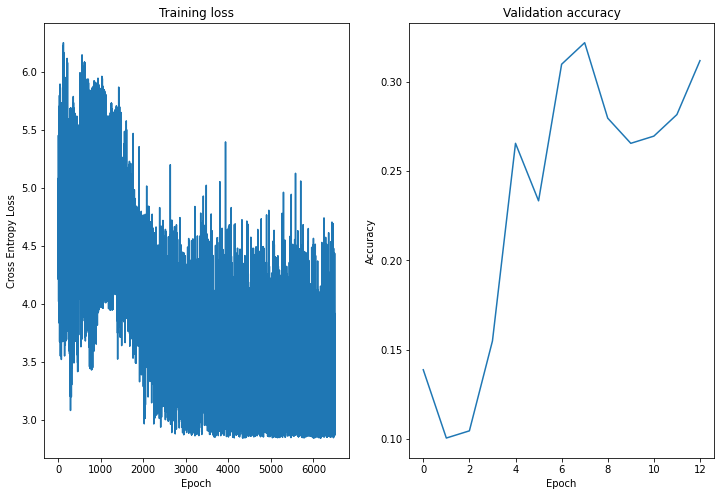

In [51]:
# let's train on george's augmented data
num_epochs = 30
lr = 0.0001

criterion = nn.NLLLoss()

# using the same model architecture
model = ConformerClassifier(
    input_dim=80, 
    n_classes=10, 
    embeds_dim=256, 
    n_layers=2, 
    conv_expansion_factor=2, 
    linear_expansion_factor=2, 
    n_heads=4, 
    attn_head_dim=64, 
    dropout=0.2, 
    padding="same"
    ).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

losses, val_acc = train_CL(
    model=model, 
    train_dl=aug_pair_george_train_dl, 
    val_dl=dev_dl, 
    criterion=criterion, 
    optimizer=optimizer, 
    epochs=num_epochs, 
    checkpoint_name="george_specaugment_checkpoint.pt"
    )

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
axes[0].plot(losses)
axes[0].set_title("Training loss")
axes[0].set_ylabel("Cross Entropy Loss")
axes[0].set_xlabel("Epoch")

axes[1].plot(val_acc)
axes[1].set_title("Validation accuracy")
axes[1].set_ylabel("Accuracy")
axes[1].set_xlabel("Epoch")

In [ ]:
model.load_state_dict(torch.load('george_specaugment_checkpoint.pt'))
test_preds, test_labs = evaluate(model, test_dl)
test_preds = np.array(test_preds)
test_labs = np.array(test_labs)
print("Test accuracy (george, specaugment, contrastive loss): ", accuracy_score(test_labs, test_preds))

Using Conformer model along with SpecAugment augmentation and contrastive loss, we were able to obtain a test accuracy of about 34%, which is not much improvement compared to just using SpecAugment but still an improvement over the single speaker no augmentation model.